# Social Graph and Interactions - Final Project

# The Lord of the Rings books, scripts and wiki analysis

## 1 - Motivation
Why The Lord Of The Rings? Well, we could go on for a long time with this answer, but we will keep it short in three points.
* **Because it has everything.** The first question we asked ourselves was whether we could actually use this as a project. Otherwise, if data is not sufficient, the work cannot be rewarding. The answer was *yes*! The three books are easily available online, and to analyse the movies we could easily find the three complete scripts. For the network, the wiki provides a great starting point; it doesn't have a lot of nodes, though, so even if a lot of results are interesting we decided to analyse two more networks extracted from the scripts, as you will see later. With such a huge amount of text, all the tools from NLTK are applicable with good results. We have dug into different online sources to make sure to pick the best books and script versions; and we believe we did! One thing we have learned from this course, though, is that no data is perfect, but chosing the best option can save at least some time! Here are our sources:
    * Book 1:   http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_1__en.htm
    * Book 2:   http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_2__en.htm
    * Book 3:   http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_3__en.htm
    * Script 1: http://www.imsdb.com/scripts/Lord-of-the-Rings-Fellowship-of-the-Ring,-The.html
    * Script 2: http://www.imsdb.com/scripts/Lord-of-the-Rings-The-Two-Towers.html
    * Script 3: http://www.imsdb.com/scripts/Lord-of-the-Rings-Return-of-the-King.html
    * Wiki:     http://lotr.wikia.com/wiki/Main_Page

* **Because it is complex.** Well, we didn't really *fear* to be left with too few things to do. But that's a question that we asked ourselves as well. Maybe we will just find Frodo popping up everywhere, "fellowship" and "ring" will be the first word in every count, and guess which word will be the biggest one in Gollum's wordcloud? Well, *not the one you would expect*! Our dataset is never obvious; the good old JRR has set up a good solid structure, and his fans have built up even more data to work on, well connected and interesting! This makes up for a great dataset!

* **Because we are nerd(ish).** Well, we may not be the real kind of nerds that one could think of, but we are pretty passionate about fantasy. We wanted to try and explore a universe that is interesting for us; and we may not be able to use it for the new groundbreaking start-up. But we can do that in the future: when does it happen again to have the opportunity to do a course project on "Lord of the Rings"? Furthermore, we may discover some interesting facts...

So, let's begin our journey!

*It's the job that's never started that takes longest to finish.*


---

## 2 - Basic stats. Let's understand the dataset better

### 2.1 - The Wiki
The first network generated from the pages of the Wiki was built using [this dataset](http://s3.amazonaws.com/wikia_xml_dumps/l/lo/lotr_pages_current.xml.7z), which provides, through a well-formatted XML file, the whole content of the Wiki. The size of the dataset is around 50 MB. We extracted the relevant information from the XML file and generated a network of characters, cities and name of battles, where all these represent nodes, while the links (edges, in a formal network syntax) are represented by the Wiki links inside each page. Wiki links are nothing but simple links with a specific syntax commonly used by many Wikis including the most famous Wikipedia.

### 2.2 - The Books

### 2.3 - The Scripts
The scripts are a bit of a mess. Each one is formatted differently, and frequently enough a non-ascii character pops up (sometimes with a meaning, e.g. the accent on Theoden's first 'e', but sometimes totally random, as some centered-dots). We decided to work with the *unidecoded* version, that transforms each fancy unicode character to its closest ASCII counterpart. This allows to search for a name in the wiki data (and make our datasets communicate), as well as guaranteeing that the three scripts have just the same format regarding names and spellings.

Note that the scripts have a different encoding than the books: whereas the formers are encoded in Latin1 (iso-8859-1), the latters are encoded in cp1251 (what?) which gave us some problems in handling the data at some point. To get only the script from the web page, on the other hand, we could easily pick the content of the HTML-tag *pre*.

The script lengths are between 1100 and 2300 lines (yes, the Return of the King is long), with around 25000-30000 words in total for each movie. The characters that speak in the movies are around 100, and no two female ever talk to each other (... Or do they? Read on!).

---

## 3 - Tools, theory and analysis. Describe the process of theory to insight

### 3.1 - Collecting the pages and the wiki links

Path setup to have the notebook work in different machines

In [1]:
fontpath = None # 'C:\\Windows\\Fonts\\RINGM__.ttf'
general_path = "../"
path_to_pictures = "pictures/"


Useful imports

In [2]:
# parsing and encoding
import json, ujson, xmltodict, re, urllib2, codecs
from HTMLParser import HTMLParser
from unidecode import unidecode

# networking and plotting
import networkx as nx
import community
from matplotlib import pyplot as plt
%matplotlib inline

# advanced type handling
import operator, math, string, random
import numpy as np
from toolz import dissoc
from __future__ import division
from string import punctuation

# printing and imaging
import pprint
from prettytable import PrettyTable
from PIL import Image

# language processing and sentiment
import nltk
from nltk.corpus import stopwords
import wordcloud
stopwords_EN = nltk.corpus.stopwords.words('english')
from bs4 import BeautifulSoup
#from BeautifulSoup import BeautifulSoup, Comment

The following function will be used to display output in a nicer way, using **PTable**:

In [3]:
def print_table(data,column_names):
    table = PrettyTable()
    table.field_names = column_names
    for row in data:
        table.add_row(row)
    print table

Parsing the XML file in order to get a dictionary, which is easier to handle:

In [4]:
with open(general_path+"lotr_pages_current.xml") as f:
    parsed = xmltodict.parse(f.read())

Here we define a function for cleaning a raw text and extract the relevant **wiki links**, which will be returned as a list:

In [5]:
 #Removing wiki links to filter out
def clean_up(raw):
    raw = re.sub(r'\[\[(?:.+?\|)?[cC]ategory.*?\]\]','',raw)
    raw = re.sub(r'\[\[(?:.+?\|)?[lL]ist.*?\]\]','',raw)
    raw = re.sub(r'\[\[(.*Hobbits.*?)\]\]','',raw)
    raw = re.sub(r'\[\[(.*Peter\ Jackson.*?)\]\]','',raw)
    raw = re.sub(r'\[\[(.*Tolkien.*?)\]\]','',raw)
    raw = re.sub(r'\[\[(?:.+?\|)?#.*?\]\]','',raw)
    raw = re.sub(r'\[\[([a-z].+?)\]\]','',raw)
    raw = re.sub(r'\[\[(File.+?)\]\]','',raw)
    matches = re.findall(r'\[\[(.+?)\]\]',raw)
    return matches

#Removing duplicate pages due to REDIRECTS
def find_redirects(raw):
    if '#REDIRECT' in raw or '#redirect' in raw:
        return True
    else:
        return False

A convenient way to get all the necessary nodes and wiki links to build the network, is to access those pages that list all the elements we are interested in, like *list of characters, battles, cities and deaths* and clean up their raw text in order to get all the pages of each category. We save this elements in four different lists, and we'll use these lists to build the nodes of the network. Special treatment for the list of deaths, that we'll use later on.

In [6]:
#Dictionary with all the pages as keys
all_pages = parsed['mediawiki']['page']
raw_text = {}

#For each category (characters,battles,cities,deaths) we save the raw text
for page in all_pages:
    if page['title']=='List of characters':
        raw_text['characters'] = page['revision']['text']['#text']        
    elif page['title']=='Battles':
        raw_text['battles'] = page['revision']['text']['#text']        
    elif page['title']=='List of deaths in the Lord of the Rings films':
        raw_text['deaths'] = page['revision']['text']['#text']        
    elif page['title']=='Cities':
        raw_text['cities'] = page['revision']['text']['#text']

#Removing possible duplicates and cleaning up the raw text of each category
list_of_characters = list(set(clean_up(raw_text['characters'])))
list_of_battles = list(set(clean_up(raw_text['battles'])))
list_of_deaths = list(set(clean_up(raw_text['deaths'])))
list_of_cities = list(set(clean_up(raw_text['cities'])))

#REMOVING REDIRECTS
list_of_characters = [elm for elm in list_of_characters
                      if not find_redirects(page['revision']['text']['#text'])
                                             for page in all_pages
                                             if page['title'] == elm]
list_of_battles = [elm for elm in list_of_battles
                      if not find_redirects(page['revision']['text']['#text'])
                                             for page in all_pages
                                             if page['title'] == elm]
list_of_cities = [elm for elm in list_of_cities
                      if not find_redirects(page['revision']['text']['#text'])
                                             for page in all_pages
                                             if page['title'] == elm]
list_of_deaths = [elm for elm in list_of_deaths
                      if not find_redirects(page['revision']['text']['#text'])
                                             for page in all_pages
                                             if page['title'] == elm]

Now that we saved all the titles of the pages we're interested in analyzing, we need to analyze their content and extract the wiki links. We'll iterate again through all the pages and save the raw text of each page. Next, we'll clean up again this text and extract the wiki links as we did before.

In [7]:
wiki_links = {}
wiki_links['characters'] = {}
wiki_links['cities'] = {}
wiki_links['battles'] = {}
edges = []

for page in all_pages:
    if page['title'] in list_of_characters:
        wiki_links['characters'][page['title']] = page['revision']['text']['#text']
    elif page['title'] in list_of_cities:
        wiki_links['cities'][page['title']] = page['revision']['text']['#text']
    elif page['title'] in list_of_battles:
        wiki_links['battles'][page['title']] = page['revision']['text']['#text']

for key in wiki_links:
    for page in wiki_links[key]:
        wiki_links[key][page] = clean_up(wiki_links[key][page])
        # Worth saying that we keep those wiki links that are contained in one of those 
        #  lists we created in the previous cell
        wiki_links[key][page] = [elm for elm in wiki_links[key][page]
                               if elm in list_of_characters
                               or elm in list_of_battles
                               or elm in list_of_cities]
        edges.extend([(page,elm) for elm in wiki_links[key][page]])
edges = list(set(edges))

### 3.2 - Network Analysis
Now we build the directed graph; as you can easily see, the nodes of the graph will be characters, cities and names of battles. Both the color and the size represent the node degree (the higher the degree,the bigger the node and the darker the color)

In [8]:
G = nx.DiGraph()
G.add_nodes_from(list_of_characters)
G.add_nodes_from(list_of_battles)
G.add_nodes_from(list_of_cities)
G.add_edges_from(edges)

The graph has 653 nodes (32 isolated)
The graph has 3971 edges


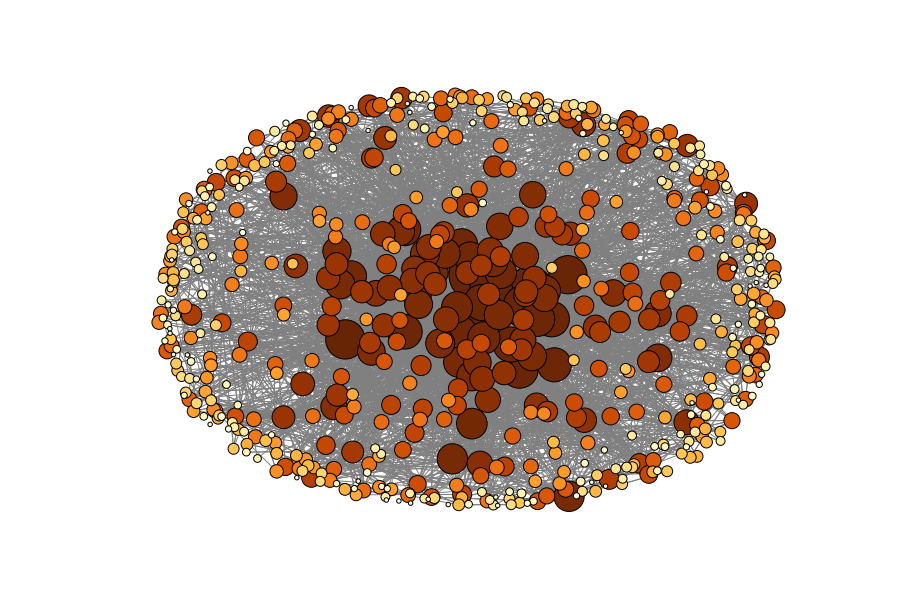

In [9]:
print 'The graph has',len(G.nodes()),'nodes',
a = len(nx.isolates(G))
if a == 0:
    print 'and is connected'
else:
    print '(%d isolated)' % a
print 'The graph has',len(G.edges()),'edges'
plt.figure(figsize=(12,8))

nodes = sorted(G.nodes(), key = G.degree, reverse=True)
degrees = sorted([G.degree(node) for node in nodes], reverse=True)
pos = nx.spring_layout(G,k=1/(np.sqrt(len(nodes))/20))
nx.draw(G,
        pos,
        cmap=plt.cm.YlOrBr_r,
        edge_color='gray',
        nodelist=nodes,
        node_size=[20*(d+1) for d in degrees],
        node_color=range(len(G.nodes())),
        arrows=False)
plt.savefig(path_to_pictures+'full_network.png')
plt.show()

It would be interesting to see which of tese big nodes are in fact characters! So let's add some color to show that (no modification in the size)...

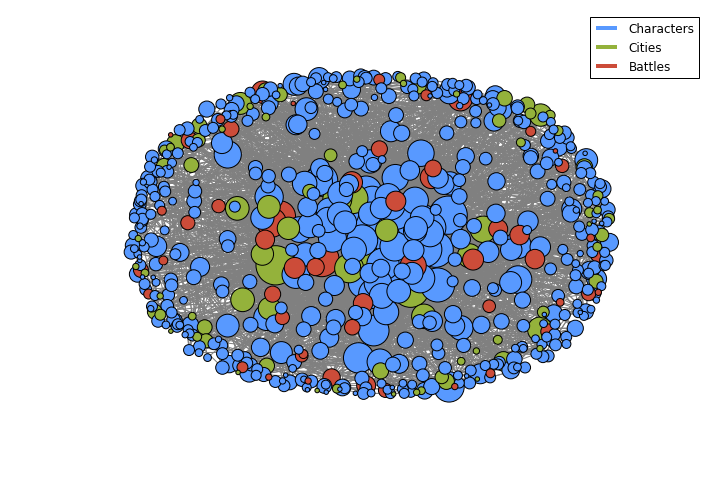

In [10]:
plt.figure(figsize=(12,8))

colors = []
for n in nodes:
    if n in list_of_battles:
        colors.append('#CC4C39')
    elif n in list_of_characters:
        colors.append('#5899FF')
    elif n in list_of_cities:
        colors.append('#94B23B')
    else:
        colors.append('#FFFFFF')

# Hack to add a legend
plt.hlines(0,0,0,label='Characters',colors='#5899FF', linewidth=4)
plt.hlines(0,0,0,label='Cities',colors='#94B23B',linewidth=4)
plt.hlines(0,0,0,label='Battles',colors='#CC4C39',linewidth=4)

plt.legend()
nx.draw(G,
        pos,
        edge_color='gray',
        nodelist=nodes,
        node_size=[20*(d+1) for d in degrees],
        node_color=colors,
        arrows=False)
plt.savefig(path_to_pictures+'full_network_and_categories.png')
plt.show()

#### 3.2.1 - Centrality and graph statistics

We will need some graph statistics in various parts of the notebook, so we wrap them in a function for convenience.

In [11]:
def graph_nodes_stats(Gr):
    data = sorted(nx.betweenness_centrality(Gr).iteritems(),key=operator.itemgetter(1),reverse=True)[:10]
    print_table(data,['Node','Betweenness Centrality'])

    data = sorted(nx.eigenvector_centrality(Gr).iteritems(),key=operator.itemgetter(1),reverse=True)[:10]
    print_table(data,['Node','Eigenvector Centrality'])

    all_degrees_values = Gr.degree().values()
    all_degrees = sorted(Gr.degree().iteritems(), key=operator.itemgetter(1), reverse=True)
    
    if isinstance(Gr, nx.DiGraph):
        in_deg_values = sorted(Gr.in_degree().values())
        in_degree = sorted(Gr.in_degree().iteritems(), key=operator.itemgetter(1), reverse=True)

        out_deg_values = sorted(Gr.out_degree().values())
        out_degree = sorted(Gr.out_degree().iteritems(), key=operator.itemgetter(1), reverse=True)

    print 'Average degree:', np.average(all_degrees_values)
    print 'Median Degree:', np.median(all_degrees_values)
    if isinstance(Gr, nx.DiGraph):
        print 'Average in-degree:', np.average(in_deg_values)
        print 'Average out-degree:', np.average(out_deg_values)
    print '\nTop degree values:\n'
    print_table(all_degrees[:10],['Node','Degree'])
    if isinstance(Gr, nx.DiGraph):
        print '\nTop in-degree values:\n'
        print_table(in_degree[:10],['Node','Degree'])
        print '\nTop out-degree values:\n'
        print_table(out_degree[:10],['Node','Degree'])

... and now let's see what are the numbers for our wiki graph!

In [12]:
graph_nodes_stats(G)

+----------------------+------------------------+
|         Node         | Betweenness Centrality |
+----------------------+------------------------+
|        Sauron        |     0.143590578864     |
|       Gandalf        |    0.0741412431694     |
|  Aragorn II Elessar  |    0.0614710296562     |
|      Galadriel       |    0.0514085102322     |
|       Isildur        |    0.0457204460073     |
|        Elrond        |    0.0449688443148     |
|     Minas Tirith     |    0.0431990441545     |
|        Umbar         |    0.0410685370346     |
|       Saruman        |    0.0368799242238     |
| Witch-king of Angmar |    0.0355133218318     |
+----------------------+------------------------+
+--------------+------------------------+
|     Node     | Eigenvector Centrality |
+--------------+------------------------+
|    Sauron    |     0.366451927533     |
|    Elrond    |     0.24497381971      |
|   Gandalf    |     0.216553483135     |
|  Galadriel   |     0.208281097753     |
|  Riv

Let us compute and plot the giant connected component and plot it with some labels that popped out in the previous tables...

The giant connected component has 610 nodes
The giant connected component has 3099 edges


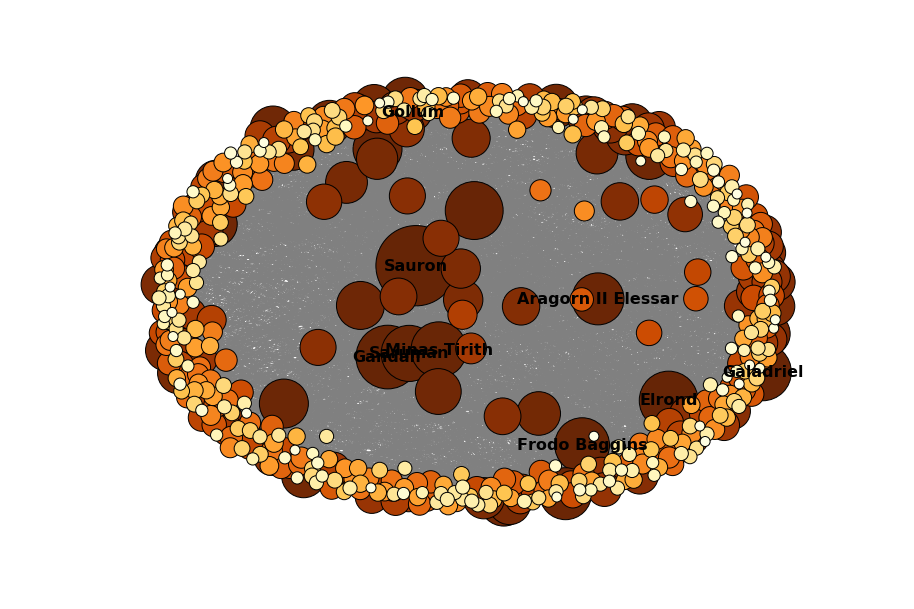

In [13]:
gcc = sorted(nx.connected_component_subgraphs(G.to_undirected()),key=len,reverse=True)[0]
print 'The giant connected component has',len(gcc.nodes()),'nodes'
print 'The giant connected component has',len(gcc.edges()),'edges'
plt.figure(figsize=(12,8))

nodes = sorted(gcc.nodes(), key = gcc.degree, reverse=True)
degrees = sorted([gcc.degree(node) for node in nodes], reverse=True)
pos = nx.spring_layout(gcc,k=1/(np.sqrt(len(nodes))/45))

nx.draw(gcc,
        pos,
        cmap=plt.cm.YlOrBr_r,
        edge_color='gray',
        nodelist=nodes,
        node_size=[50*(d+1) for d in degrees],
        node_color=range(len(gcc.nodes())),
        arrows=False)
labels={node:node for node in ['Minas Tirith','Sauron','Frodo Baggins','Gandalf','Gollum',
                               'Galadriel','Aragorn II Elessar','Elrond','Saruman']}
nx.draw_networkx_labels(gcc,pos,labels,font_size=16,font_weight='bold')
plt.savefig(path_to_pictures+'giant_component.png')
plt.show()

#### 3.2.2 - Degree distribution

We've seen the nodes with the highest degree, but we want to have a more complete insight into the network degrees, so linear and loglog plots of the degree follow...

In [14]:
all_degrees_values = G.degree().values()
all_degrees = sorted(G.degree().iteritems(), key=operator.itemgetter(1), reverse=True)

in_deg_values = sorted(G.in_degree().values())
in_degree = sorted(G.in_degree().iteritems(), key=operator.itemgetter(1), reverse=True)

out_deg_values = sorted(G.out_degree().values())
out_degree = sorted(G.out_degree().iteritems(), key=operator.itemgetter(1), reverse=True)


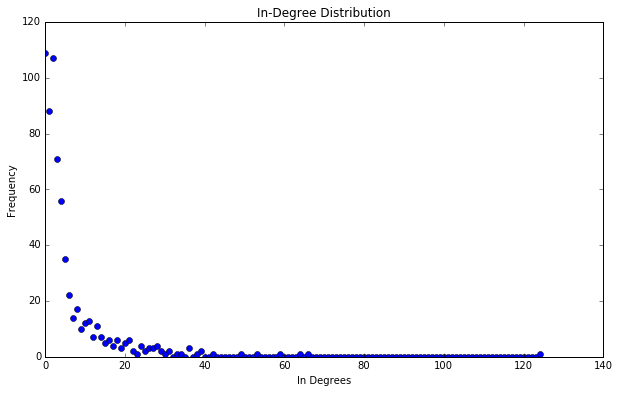

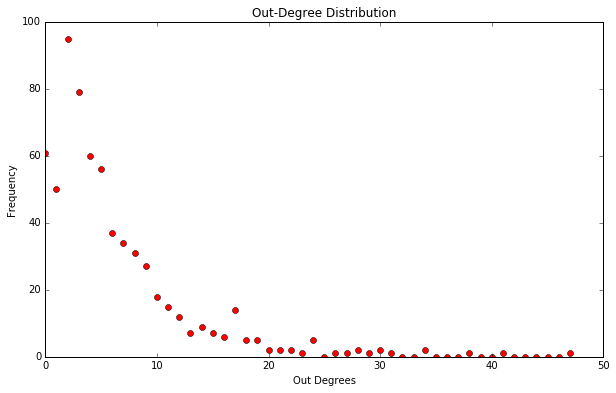

In [15]:
bins_in = range(min(in_deg_values),max(in_deg_values))
hist_in,bin_edges = np.histogram(in_deg_values, max(in_deg_values))
bins_out = range(min(out_deg_values),max(out_deg_values))
hist_out,bin_edges = np.histogram(out_deg_values, max(out_deg_values))

plt.figure(figsize=(10,6))
plt.plot(bins_in,hist_in,'bo')
plt.title("In-Degree Distribution")
plt.xlabel('In Degrees')
plt.ylabel('Frequency')

plt.figure(figsize=(10,6))
plt.plot(bins_out,hist_out,'ro')
plt.title("Out-Degree Distribution")
plt.xlabel('Out Degrees')
plt.ylabel('Frequency')
plt.show()

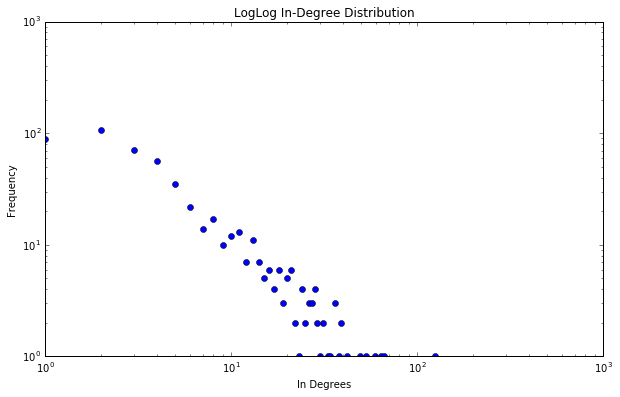

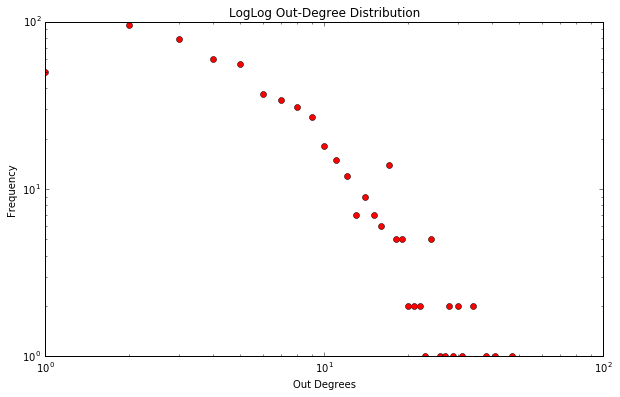

In [16]:
plt.figure(figsize=(10,6))
plt.loglog()
plt.plot(bins_in,hist_in,'bo')
plt.title("LogLog In-Degree Distribution")
plt.xlabel('In Degrees')
plt.ylabel('Frequency')

plt.figure(figsize=(10,6))
plt.loglog()
plt.plot(bins_out,hist_out,'ro')
plt.title("LogLog Out-Degree Distribution")
plt.xlabel('Out Degrees')
plt.ylabel('Frequency')
plt.show()

#### 3.2.3 - Community detection

Partitioned in sets of size: [73, 168, 59, 56, 67, 11, 10, 147, 12, 3, 4]


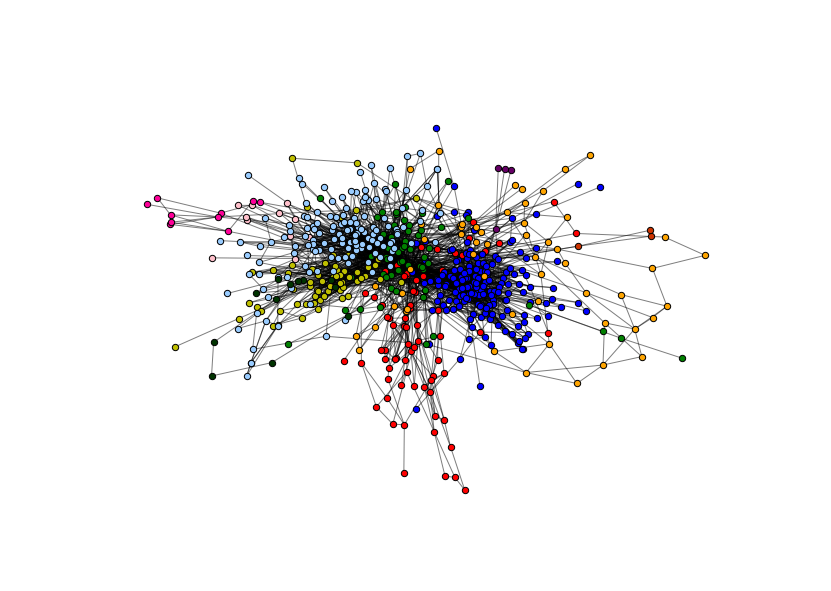

In [17]:
#first compute the best partition
partition = community.best_partition(gcc)

print 'Partitioned in sets of size:',
print [partition.values().count(i) 
       for i in range(0, len(set(  partition.values()  )))
      ]

#drawing
colors = ['r','b','g','orange','y','pink','#FF0099','#99ccff','#003300','#cc3300','#660066','#ffffcc','#003366']
size = float(len(set(partition.values())))
layout_k_ba = .5 / (np.sqrt( len(gcc.nodes()) )) # half the default split factor
pos = nx.spring_layout(gcc,k=layout_k_ba)
count = 0.
plt.figure(num=4,figsize=(14,10))
for com in set(partition.values()) :
    count+=1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    color = colors.pop(0)
    nx.draw_networkx_nodes(gcc, pos, list_nodes, node_size = 40,
                                node_color = color)

plt.axis('off')
nx.draw_networkx_edges(gcc,pos, alpha=0.5)
plt.savefig(path_to_pictures+'communities.png')
plt.show()

Nice, but let us try to have a drawing that shows better the dimensions and relations

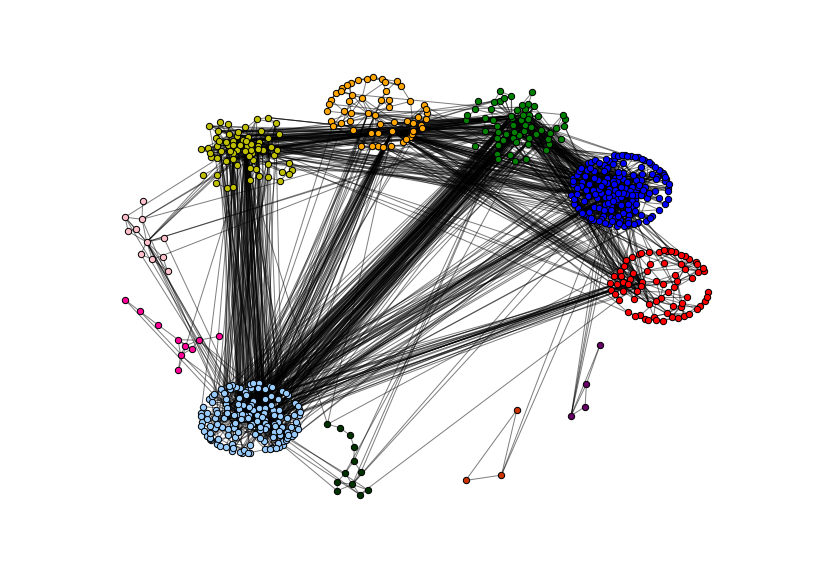

In [18]:
#drawing
colors = ['r','b','g','orange','y','pink','#FF0099','#99ccff','#003300','#cc3300','#660066','#ffffcc','#003366']

layout_k_ba = 3 / (np.sqrt( len(gcc.nodes()) )) # half the default split factor
count = 0.

angle = (2.0 * np.pi) / len(set(partition.values()))
scale = 2.5
nums = np.arange( 0.0 , 2.0 * np.pi , angle )
offsets = np.asarray([(scale * np.cos(a) , scale * np.sin(a)) for a in nums])

plt.figure(num=4,figsize=(14,10))

allpos = dict()
xm = xMM =ym =yMM = 0
for j, com in enumerate( set(partition.values()) ):
    count+=1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    
    pos = nx.spring_layout(gcc.subgraph(list_nodes),k=layout_k_ba)

    for k in list_nodes:
        pos[k] = [
            pos[k][0] + offsets[j][0],
            pos[k][1] + offsets[j][1] ]
        xm  = min(xm , pos[k][0])
        xMM = max(xMM, pos[k][0])
        ym  = min(ym , pos[k][1])
        yMM = max(yMM, pos[k][1])

    color = colors.pop(0)
    nx.draw_networkx_nodes(list_nodes, pos, list_nodes, node_size = 40,
                                node_color = color)
    allpos.update(pos)

nx.draw_networkx_edges(gcc,allpos, alpha=0.5)
plt.xlim( xm-1, xMM+1 )
plt.ylim( ym-1, yMM+1 )
plt.axis('off')
plt.savefig(path_to_pictures+'communities_esploso.png')
plt.show()

Calculation of the **modularity**:

In [19]:
total_links = len(gcc.edges())

def compute_edges_length(race):
    links = []
    edges = gcc.subgraph(race).edges(race)
    for edge in edges:
        if edge[0] in race and edge[1] in race:
            links.append(edge)
    return len(links)

def compute_degrees(race):
    return sum([gcc.subgraph(race).degree(node)
                                           for node in race
                                           if isinstance(gcc.subgraph(race).degree(node), int)])

# Compute modularity
def modularity(races):
    module = 0
    for branch in races.keys():
        module += races[branch]['links']*1.0/total_links - races[branch]['degrees']*1.0/(2*total_links)**2
    return module

communities = {}
for i in range(int(size)):
    communities[str(i)] = {'characters':[key for key, value in partition.iteritems() if value == i]}
    communities[str(i)]['links'] = compute_edges_length(communities[str(i)]['characters'])
    communities[str(i)]['degrees'] = compute_degrees(communities[str(i)]['characters'])
print 'Number of communities is:',size
print 'The modularity is:',modularity(communities)

Number of communities is: 11.0
The modularity is: 0.746249375638


Our implementation of the algorithm, choosing the communities depending on the **races** of the characters, the **places** and the **battles**:

In [20]:
#Function used to detect the race of a character, according to the Wiki: it must be extracted with regex
def find_race(raw):
    match = re.search(r'(?:[Rr]ace *= *)(.*)(?:\n)',raw)
    if match!=None:
        race = match.groups()[0]
        race = re.sub(r'\[\[','',race)
        race = re.sub(r'\]\]','',race)
        return race
    return None

races = {}
for page in all_pages:
    if page['title'] in list_of_characters:
        race = find_race(page['revision']['text']['#text'])
        if race!=None and race!='' and race!='Unknown':
            races[page['title']] = race

The dictionary `categories` will be used to simulate the previous `communities` dictionary, such that we collect there all the nodes of each category, with the needed parameters in order to calculate the modularity. We call it *categories* and not simply *races* because we take in consideration also *cities* and *battles*, which are included in the giant connected component, where previously we already calculated the modularity.

In [21]:
categories = {}
for character in races:
    if character not in gcc.nodes():
        continue
    try:
        categories[races[character]]['elements'].append(character)
    except KeyError:
        categories[races[character]] = {'elements': [character]}
categories['*Cities*'] = {}
categories['*Battles*'] = {}
categories['*Cities*']['elements']  = [a for a in list_of_cities  if a in gcc.nodes()]
categories['*Battles*']['elements'] = [a for a in list_of_battles if a in gcc.nodes()]


Since the races are not clean (there are some duplications), we merge them:

In [22]:
def normalize_race (race):
    if race=='Ainur ' or race=='Ainur (Maiar)':
        return 'Ainur'
    elif race in ['Book : Unknown, Film : Orc', 'Uruk-hai (book)/Orc (film)',
                  'Black Uruk', 'Uruk-hai','Goblin/Orc', 'Orc']:
        return 'Orcs'
    elif race=='Dwarven' or race=='Dwarf':
        return 'Dwarves'
    elif race=='Elves ' or race=='Elf':
        return 'Elves'
    elif race=='Great Eagles':
        return 'Eagles'
    elif race=='Great Spiders':
        return 'Giant Spiders'
    elif race=='Half-elven (Elves and Maiar)' or race=='Half-elven, later Men':
        return 'Half-elven'
    elif race=='Hobbits|Hobbit' or race=='Hobbit':
        return 'Hobbits'
    elif race=='Maiar':
        return 'Maiar (Balrogs)'
    elif race in ['Man (Skin-changer)', 'Men ', 'Men (Rohirrim)', 'Men (Skin-changer)', 
                      'Men, later Wraith', 'Men-Wraith']:
        return 'Men'
    elif race=='Trolls|Troll (Hill troll)':
        return 'Stone-trolls'
    elif race=='Werewolves ':
        return 'Werewolves'
    else:
        return race

for category in categories:
    norm = normalize_race(category)
    if norm != category:
        categories[norm]['elements'].extend(categories[category]['elements'])
        
categories = dissoc(categories,'Ainur ','Ainur (Maiar)','Book : Unknown, Film : Orc','Goblin/Orc','Orc',
                    'Dwarven','Dwarf','Elves ','Elf','Great Eagles','Great Spiders',
                    'Half-elven (Elves and Maiar)','Half-elven, later Men','Hobbits|Hobbit',
                    'Hobbit','Maiar','Man (Skin-changer)','Men ','Men (Rohirrim)','Men (Skin-changer)',
                    'Men, later Wraith','Men-Wraith','Trolls|Troll (Hill troll)','Uruk-hai (book)/Orc (film)',
                    'Werewolves ','Black Uruk','Uruk-hai')

And we compute the edges length and the degrees, exactly as before:

In [23]:
for category in categories:
    categories[category]['links'] = compute_edges_length(categories[category]['elements'])
    categories[category]['degrees'] = compute_degrees(categories[category]['elements'])

Finally, we calculate the modularity:

In [24]:
print 'Number of user-defined categories:',len(categories)
print 'The modularity is:',modularity(categories)

Number of user-defined categories: 19
The modularity is: 0.33747377731


Mmmm good, so the communities from the races are not so good! But let's see if at least one has been recognized by the automated algorithm!

In [25]:
def prettyconfusion (rowhead, confusion):
    if len(rowhead) != len(confusion):
        return 'ERROR'
    s = ''
    for i in range(len(rowhead)):
        if s != '':
            s += '\n'
        s += '%15s' % rowhead[i]
        for e in confusion[i]:
            s += ('%4d' % e) + ' '
    return s

names = []
conf_m =[]
for k,v in categories.iteritems():
    row = [0] * len(set(partition.values()))
    names.append(k)
    for node in v['elements']:
        index = partition[node]
        row[index] += 1
    conf_m.append(row)
        
print prettyconfusion(names, conf_m)


     Half-elven   0    5    2    0    0    0    0    2    0    0    0 
        Dwarves   0    1    0    0   23    0    0    1    0    0    3 
        Hobbits   0    0    0    0    4    2    0   18    1    0    0 
            God   0    1    0    0    0    0    0    0    0    0    0 
Maiar (Balrogs)   0    1    0    1    2    0    0    1    0    0    0 
         Eagles   0    1    0    0    0    0    0    2    0    0    0 
          Elves   1   48    9    0    2    0    0    3    0    3    0 
          Raven   0    0    0    0    2    0    0    0    0    0    0 
            Men  57   38   29   38   16    2    9   58   10    0    1 
  Giant Spiders   0    1    0    0    0    0    0    1    0    0    0 
           Orcs   0    0    0    0    2    0    0    7    0    0    0 
          Ainur   0   21    0    0    0    0    0    0    0    0    0 
      *Battles*   3   18    3    5    6    0    1   16    0    0    0 
       Drúedain   0    0    0    0    0    0    0    1    0    0    0 
  Ents

Looks like the Dwarves make a pretty good community, since Louvaine algorithm identifies 23 out of 28 of them to belong to the same community! They seem to connect mostly with humans, since that's the second most common race in that community! Also hobbits cluster together pretty well.
One would expect elves to form a close group, and in fact 48 of 66 are in the same group; the Men on the other hand are spread over **all** the communities. 
Battles and cities form communities together (in particular two) but are not very compact overall.
Finally, the two dragons are not in the same communities, and all the Ainur are in the same communities (together with all the elves).


### 3.3 - In-Depth Wiki Text Mining

The text of the Wiki is not relevant to conduct a sentiment analysis, so we list what could be interesting to analyse:
* **Random shortest path similarities**: how much do the contents of the pages that represent the shortest paths of the network differ by each other?
* **Relevant words per character**: which are the most frequent words that characterize the most important characters of the universe?
* **Relevant words per race**: which are the most frequent words that characterize the races of LOTR?
* **Most frequent words for places/battles**
* **Most frequent words**: word cloud of the most frequent words of the universe.

#### 3.3.1 - Shortest path similarities
This analysis need to extract the text from all the pages that represent the nodes in out network, calculate the shortest paths, and calculate the similarities of the pages.

In [26]:
#Here we extract the raw text of each page
pages_text = {}
for page in all_pages:
    if page['title'] in list_of_characters or page['title'] in list_of_battles or page['title'] in list_of_cities:
        pages_text[page['title']] = page['revision']['text']['#text']

In [27]:
def clean_texts(text,page_name):
    #Removing page title
    for elm in page_name.split():
        text = text.replace(elm,'')
    
    #Removing HTML syntax elements (e.g. &quot;)
    text = re.sub(r'&\w*;','',text)
    text = re.sub(r'[/;]ref','',text)
    text = re.sub(r'&lt;references/&gt;','',text)
    text = re.sub(r'\.jpg|\.png','',text)
    
    #Removing hyperlinks
    text = re.sub(r'https?://[\w\d./]+|www\.[\w\d./]+','',text)
    
    #Removing digits
    text = re.sub(r'\d+','',text)
    
    #Removing subtitles included in between couples of '=='
    text = re.sub(r'==[\w\s]*==','',text)
    
    #Removing useless wiki links
    text = re.sub(r'\[\[File:.*\]\]','',text)
    text = re.sub(r'\[\[(?:.+?\|)?[cC]ategory.*?\]\]','',text)
    text = re.sub(r'\[\[(?:.+?\|)?[lL]ist.*?\]\]','',text)
    
    #Removing second link in wiki links (e.g. Frodo Baggins|Frodo)
    text = re.sub(r'\|.*?\]\]','',text)
    
    #Removing dates (e.g. starting with TA/SA or FO)
    text = re.sub(r'[TS]A\ \d+|FO\ \d+','',text)
    
    #Removing not relevant parts of the text (Infobox and similars)
    text = re.sub(r'{{.*}}','',text)
    text = re.sub(r'{{Infobox.*','',text)
    text = re.sub(r'\|\ *\w*\ *=\ *.*','',text)
    
    #Removing weird characters
    #text = ''.join(c for c in text if c not in punctuation)
    text = re.sub(r'[^\w-]+',' ',text)
    
    #Tokenize, transform to lower-case and remove stopwords
    tokens = [word.strip(string.punctuation) for word in text.split()]
    #tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens
              if word.lower() not in stopwords_EN and len(word)>2]
    return tokens

print 'Tokenizing and cleaning the texts, current progress:'
counter=0

for page in pages_text:
    pages_text[page] = clean_texts(pages_text[page],page)
    counter+=1
    if counter%200==0:
        print counter,'plain texts analyzed'
print 'Done!'

#I create a unique set of words and a list of all (not unique) words, used later for calculating FreqDist
#Indeed, all_words contains all unique words within each document
set_all_words = set()
all_words = []
for page in pages_text:
    words_in_article = set()
    for word in pages_text[page]:
        words_in_article.add(word)
        set_all_words.add(word)
    all_words.extend(words_in_article)

#I create a list representation of the set, sorted alphabetically
list_unique_words = sorted(set_all_words)

#Free memory
del set_all_words

Tokenizing and cleaning the texts, current progress:
200 plain texts analyzed
400 plain texts analyzed
600 plain texts analyzed
Done!


In [28]:
print 'Total unique words:',len(list_unique_words)
print 'Sum of the total unique words per each article:',len(all_words)

Total unique words: 16941
Sum of the total unique words per each article: 118362


The dictionary `freq_corpus` is the result of the FreqDist calculated over the list of all words, unique for each article. This means that accessing a word through `freq_corpus[word]` will say the number of articles that contain that word. This is a convenient way to calculate the IDF:

In [29]:
total_texts = len(pages_text)
freq_corpus =  nltk.FreqDist(all_words)

#Calculating the IDF for each unique word:
idf = {}
for word in list_unique_words:
    idf[word] = np.log(total_texts/freq_corpus[word])

I easily calculate the TF for each article with `nltk.FreqDist`:

In [30]:
tf = {}
for page in pages_text:
    tf[page] = nltk.FreqDist(pages_text[page])

Now we can finally calculate the **TF-IDF vector** for each page:

In [31]:
tf_idf = {}

#Iterating over all the articles (one TF-IDF vector per article)
for page in pages_text:
    
    #Initializing the TF-IDF vector
    tf_idf[page] = {}

    #Iterating over the words of the text
    for word in pages_text[page]:
        tf_idf[page][word] = tf[page][word]*idf[word]

The following functions are the one needed to calculate the **cosine similarity** between two vectors $a$ and $b$:

In [32]:
def vector_length(vector):
    summ=0.0
    for word in vector:
        summ+=vector[word]**2
    return np.sqrt(summ)

def vector_product(a,b):
    if len(a.keys())>len(b.keys()):
        first_vector = a
        second_vector = b
    else:
        first_vector = b
        second_vector = a
    summ=0.0
    for key in first_vector:
        try:
            summ+=first_vector[key]*second_vector[key]
        except KeyError:
            summ+=0
    return summ

def cosine_similarity(a,b):
    return vector_product(a,b)/(vector_length(a)*vector_length(b))

Now we have to generate the shortest paths. In order to make this calculation as more random as possible, we try to generate **`N = 5000` random paths**:

In [33]:
import random as rn

N = 5000
#Will be a list of tuples (source,target) with non-repeated couples
source_target_pairs = []
for i in range(N):
    n = rn.choice(gcc.nodes())
    m = rn.choice(gcc.nodes())
    while(m==n or (m,n) in source_target_pairs or (n,m) in source_target_pairs):
        m = rn.choice(gcc.nodes())
        n = rn.choice(gcc.nodes())
    source_target_pairs.append((n,m))

In [34]:
shortest_paths_similarity = {}

counter = 0
for pair in source_target_pairs:
    source = pair[0]
    target = pair[1]
    try:
        shortest_path = nx.shortest_path(G,source,target)
        #We get rid of paths of length 2
        if len(shortest_path)<=2:
            continue
    except:
        continue
    
    #Calculation of the average similarity and the variance for the current human path
    similarities = [cosine_similarity(tf_idf[shortest_path[i]],tf_idf[shortest_path[i+1]])
                          for i in range(len(shortest_path)) if i!=len(shortest_path)-1]
    shortest_average = np.average(similarities)
    shortest_paths_similarity[source+'->'+target] = shortest_average
    counter+=1
    if counter%1000==0:
        print counter,'paths processed'
print 'Done!'

1000 paths processed
2000 paths processed
3000 paths processed
Done!


In [35]:
print 'Number of found shortest paths:',len(shortest_paths_similarity.keys())

Number of found shortest paths: 3986


In [36]:
print 'Source-Target pairs with the highest values of similarity:'
data = sorted(shortest_paths_similarity.iteritems(),key=operator.itemgetter(1),reverse=True)[:20]
print_table(data,['Source-Target','Similarity'])

Source-Target pairs with the highest values of similarity:
+-----------------------------+----------------+
|        Source-Target        |   Similarity   |
+-----------------------------+----------------+
|      Arahad I->Aravorn      | 0.549133802557 |
|    Arveleg I->Celebrindor   | 0.42143887172  |
|        Niënor->Saeros       | 0.419428762714 |
| Tar-Telperiën->Tar-Aldarion | 0.417271457679 |
|  Beren (Steward)->Thorondir | 0.373572437985 |
| Aragorn II Elessar->Aragost | 0.372301950215 |
|     Tar-Súrion->Anardil     | 0.371705533036 |
|       Ulwarth->Voronwë      | 0.370290133889 |
|    Thráin I->Helm's Deep    | 0.358592338084 |
|      Míriel->Fingolfin      | 0.352996552774 |
|       Thráin I->Dáin I      | 0.348647601904 |
|      Aravir->Arveleg II     | 0.348419187177 |
|       Gorlim->Aravorn       | 0.346801495147 |
|  Melkor->Dagor-nuin-Giliath | 0.346516488635 |
|       Araphor->Arvegil      | 0.344961611338 |
|       Thorin I->Fëanor      | 0.344575339429 |
|     Thrá

In [37]:
shortest_paths_avg_sim_values = shortest_paths_similarity.values()
print 'Mean of shortest paths similarities:',np.mean(shortest_paths_avg_sim_values)
print 'Variance of shortest paths similarities:',np.var(shortest_paths_avg_sim_values)

Mean of shortest paths similarities: 0.179153506981
Variance of shortest paths similarities: 0.002516910569


Now we plot the shortest paths similarity distribution:

In [38]:
def frange(x, y, jump):
    while x < y:
        yield x
        x+= jump

#Filling the bins for distribution
def fill_bins(values,max_value,bins):
    bins_content = [0]*len(bins)
    for value in values:
        for binn in bins:
            if value==max_value or value>=bins[-1:][0]:
                bins_content[-1:][0]+=1
            elif value>=binn and value<bins[bins.index(binn)+1]:
                bins_content[bins.index(binn)]+=1
    print 'Done!'
    return bins_content
        
print 'Total average similarity values for shortest paths:',len(shortest_paths_avg_sim_values)

#We get the min/max value of each list in order to properly bin the values
min_shortest_avg_sim = min(shortest_paths_avg_sim_values)
max_shortest_avg_sim = max(shortest_paths_avg_sim_values)

#Start creating the bins
shortest_bins = frange(min_shortest_avg_sim,max_shortest_avg_sim,0.01)
shortest_bins = [binn for binn in shortest_bins]

print 'Filling bins for shortest paths average similarity distribution:'
shortest_bins_content = fill_bins(shortest_paths_avg_sim_values,max_shortest_avg_sim,shortest_bins)

Total average similarity values for shortest paths: 3986
Filling bins for shortest paths average similarity distribution:
Done!


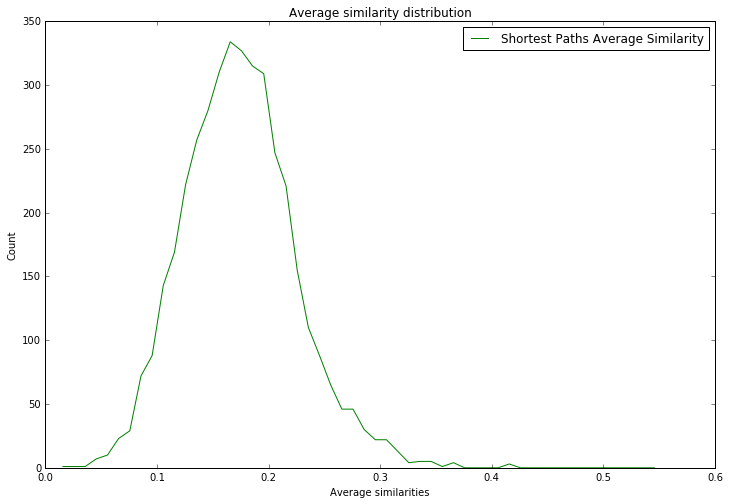

In [39]:
plt.figure(figsize=(12,8))
plt.xlabel('Average similarities')
plt.ylabel('Count')
plt.title('Average similarity distribution')
plt.plot(shortest_bins,shortest_bins_content,'g-',label='Shortest Paths Average Similarity')
plt.legend()
plt.show()

As we can see from the previous result, the average similarity of the pages in the shortest paths is not so high.

#### 3.3.2 - Relevant words per characters
Hereby we create some interesting wordclouds for the most important characters of the universe of LOTR. Since the text that belongs to each character is extracted from the Wiki, we consider reasonable that these words will describe him/her pretty well.

In [40]:
# Hue-Saturation-Lightness (HSL) functions, given as “hsl(hue, saturation%, lightness%)” where
#   hue is the colour given as an angle between 0 and 360 (red=0, green=120, blue=240), saturation
#   is a value between 0% and 100% (gray=0%, full color=100%), and lightness is a value between
#   0% and 100% (black=0%, normal=50%, white=100%). For example, “hsl(0,100%,50%)” is pure red.
def orange_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(40, 100%%, %d%%)" % random.randint(50, 70)

def generate_string(page):
    s = ''
    s+=' '.join([word for word in page for i in range(int(math.ceil(page[word])))])
    return s

def generate_wordcloud(mask,string,filename):
    wordc = wordcloud.WordCloud(
            font_path=fontpath,
            mode='RGBA',
            background_color='black',
            mask=mask,
            min_font_size=6,
            width=1800,
            height=1400,
            margin=10,
            random_state=1).generate(string)
    wordc = wordc.recolor(color_func=orange_color_func, random_state=3)
    wordc.to_file(general_path+filename+'_wordcloud.png')
    #For convenience, we won't show the wordclouds in the notebooks, since it's easier to see them in the website.
    #plt.figure(figsize=(18,14),dpi=300)
    #plt.title(page)
    #plt.imshow(wordcloud)
    #plt.axis("off")
    #plt.show()

important_characters = ['Frodo Baggins','Aragorn II Elessar','Gandalf',
                        'Legolas','Gimli','Elrond','Sauron','Gollum',
                        'Boromir','Arwen','Saruman']
mask_background = 'bg_wordcloud.jpg'
mask = np.array(Image.open(path_to_pictures+mask_background))

#Generating wordcloud
for page in tf_idf:
    if page in important_characters:
        s = generate_string(tf_idf[page])
        first_name = page.split()[0].lower()
        generate_wordcloud(mask,s,first_name)

print 'Generated!'

Generated!


#### 3.3.3 - Relevant words per race
Which are the words that distinguish each race of the universe?

In [41]:
all_races = sorted(set(races.values()))

We can clearly see that there are duplications, but it's more convenient to merge them manually later.

In [42]:
print all_races

[u'Ainur', u'Ainur ', u'Ainur (Maiar)', u'Black Uruk', u'Book : Unknown, Film : Orc', u'Dragons', u'Dr\xfaedain', u'Dwarf', u'Dwarven', u'Dwarves', u'Eagles', u'Elf', u'Elves', u'Elves ', u'Ents, Onodrim', u'Giant Spiders', u'Goblin/Orc', u'God', u'Great Eagles', u'Great Spiders', u'Half-elven', u'Half-elven (Elves and Maiar)', u'Half-elven, later Men', u'Hobbit', u'Hobbits', u'Hobbits|Hobbit', u'Maiar', u'Maiar (Balrogs)', u'Man (Skin-changer)', u'Men', u'Men ', u'Men (Rohirrim)', u'Men (Skin-changer)', u'Men, later Wraith', u'Men-Wraith', u'Orc', u'Orcs', u'Raven', u'Stone-trolls', u'Trolls|Troll (Hill troll)', u'Uruk-hai', u'Uruk-hai (book)/Orc (film)', u'Werewolves', u'Werewolves ']


Generating the string for each race:

In [43]:
races_words = {}
for character in list_of_characters:
    #If the race of the character is defined -> try branch
    try:
        if races[character] in all_races:
            try:
                races_words[races[character]]+=generate_string(tf_idf[character])
            except KeyError:
                races_words[races[character]] = generate_string(tf_idf[character])
    #The race of the character isn't defined (None or empty)
    except:
        continue

Merging the duplicate races and removing useless keys:

In [44]:
for race in races_words:
    norm = normalize_race(race)
    if norm != race:
        races_words[norm]+=races_words[race]

races_words = dissoc(races_words,'Ainur ','Ainur (Maiar)','Book : Unknown, Film : Orc','Goblin/Orc','Orc',
                     'Dwarven','Dwarf','Elves ','Elf','Great Eagles','Great Spiders',
                     'Half-elven (Elves and Maiar)','Half-elven, later Men','Hobbits|Hobbit',
                     'Hobbit','Maiar','Man (Skin-changer)','Men ','Men (Rohirrim)','Men (Skin-changer)',
                     'Men, later Wraith','Men-Wraith','Trolls|Troll (Hill troll)','Uruk-hai (book)/Orc (film)',
                     'Werewolves ')

In [45]:
print 'Total number of races:',len(races_words)
print sorted(races_words.keys())

Total number of races: 19
[u'Ainur', u'Black Uruk', u'Dragons', u'Dr\xfaedain', u'Dwarves', u'Eagles', u'Elves', u'Ents, Onodrim', u'Giant Spiders', u'God', u'Half-elven', u'Hobbits', u'Maiar (Balrogs)', u'Men', u'Orcs', u'Raven', u'Stone-trolls', u'Uruk-hai', u'Werewolves']


Finally generating the wordclouds for each race:

In [46]:
for race in races_words:
    race_name = race.replace(' ','_')
    generate_wordcloud(mask,races_words[race],race_name)

#### 3.3.4 - Most frequent words for places, battles and whole universe

In [47]:
s = ''
for page in tf_idf:
    if page in list_of_cities:
        s+= generate_string(tf_idf[page])
generate_wordcloud(mask,s,'PLACES')

In [48]:
s = ''
for page in tf_idf:
    if page in list_of_battles:
        s+= generate_string(tf_idf[page])
generate_wordcloud(mask,s,'BATTLES')

In [49]:
s=''
for page in tf_idf:
    s+= generate_string(tf_idf[page])
    s+=' '
generate_wordcloud(mask,s,'FULL')

### 3.4 - Population Analysis

#### 3.4.1 - Gender

It could be interesting extracting the **gender of the characters** and see some interesting statistics, also related to the **books/scripts**:

In [50]:
#Function used to extract the gender of a character, according to the Wiki: it must be done with regex
def find_gender(raw):
    match = re.search(r'(?:[gG]ender *= *)(.*)(?:\n)',raw)
    if match!=None:
        gender = match.groups()[0]
        gender = re.sub(r'\[\[','',gender)
        gender = re.sub(r'\]\]','',gender)
        return gender
    return None

genders = {}
for page in all_pages:
    if page['title'] in list_of_characters:
        gender = find_gender(page['revision']['text']['#text'])
        if gender!=None and gender!='' and gender!='Unknown':
            genders[page['title']] = gender

In [51]:
set(genders.values())

{u'Female',
 u'Female ',
 u'Genderless (personifies itself as Male)',
 u'Male',
 u'Male ',
 u'Males',
 u'Male|skin = White/Gray}}',
 u'male'}

So, as we already did for the races, we need to clean them in order to have just two values (male and female):

In [52]:
for key in genders:
    if genders[key].startswith('F'):
        genders[key] = 'Female'
    else:
        genders[key] = 'Male'

We can see how many **male** and **female** characters are in the LOTR universe:

In [53]:
males_number = sum([1 for key in genders if genders[key]=='Male'])
females_number = sum([1 for key in genders if genders[key]=='Female'])
percent_males = males_number*100.0/len(genders.keys())
percent_females = females_number*100.0/len(genders.keys())
data = [(males_number,females_number),('%.2f%%' %(percent_males),'%.2f%%' %(percent_females))]
print_table(data,['Male Characters','Female Characters'])

+-----------------+-------------------+
| Male Characters | Female Characters |
+-----------------+-------------------+
|       393       |         61        |
|      86.56%     |       13.44%      |
+-----------------+-------------------+


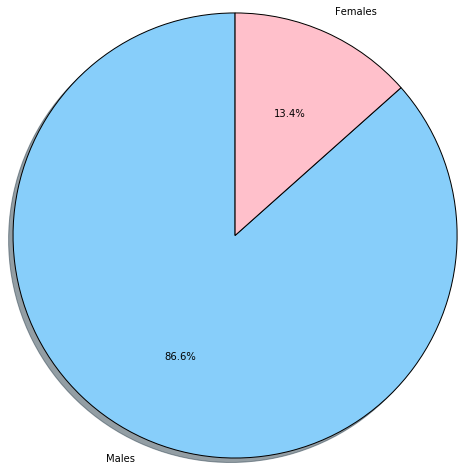

In [54]:
labels = 'Males', 'Females'
sizes = [percent_males,percent_females]
colors = ['lightskyblue','pink']

plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

So this is a clear evidence that the LOTR universe has a **big majority of male characters**.

#### 3.4.2 - Females Network

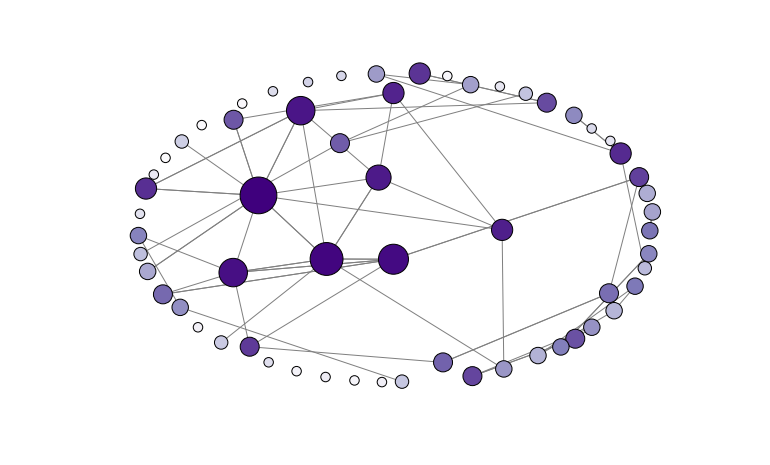

In [55]:
females_graph = G.subgraph([key for key in genders if genders[key]=='Female'])
plt.figure(figsize=(10,6))

nodes = sorted(females_graph.nodes(), key = females_graph.degree, reverse=True)
degrees = sorted([females_graph.degree(node) for node in nodes], reverse=True)

pos = nx.spring_layout(females_graph,k=1/(np.sqrt(len(nodes))/1.5))
nx.draw(females_graph,
        pos,
        cmap=plt.cm.Purples_r,
        edge_color='gray',
        nodelist=nodes,
        node_size=[90*(d+1) for d in degrees],
        node_color=range(len(females_graph.nodes())),
        arrows=False)
plt.savefig(path_to_pictures+'female_network.png')
plt.show()

In [56]:
graph_nodes_stats(females_graph)

+-----------+------------------------+
|    Node   | Betweenness Centrality |
+-----------+------------------------+
| Galadriel |     0.040725047081     |
|   Melian  |    0.0342278719397     |
|  Yavanna  |     0.025329566855     |
|    Vána   |    0.0202448210923     |
|   Arwen   |    0.0181497175141     |
|   Nienna  |    0.0101694915254     |
|   Varda   |    0.00546139359699    |
|  Gilraen  |    0.00536723163842    |
|   Vairë   |    0.00536723163842    |
|   Idril   |    0.00466101694915    |
+-----------+------------------------+
+-----------+------------------------+
|    Node   | Eigenvector Centrality |
+-----------+------------------------+
|   Melian  |     0.510820690713     |
|  Yavanna  |     0.420447529728     |
|    Vána   |     0.367535279246     |
|  Lúthien  |     0.337163672892     |
| Galadriel |     0.336502665022     |
|   Varda   |     0.248919981216     |
|   Arwen   |     0.155390591425     |
| Celebrían |     0.155390585935     |
|   Nienna  |     0.13281

#### 3.4.3 - Population by race and sex

We're going to plot a histogram representing how is the population in terms of races and gender:

In [57]:
races_gender_counter = {key:{'Males':sum([1 for elm in genders
                                         if elm in categories[key]['elements'] and genders[elm]=='Male']),
                             'Females':sum([1 for elm in genders
                                           if elm in categories[key]['elements'] and genders[elm]=='Female'])}
                        for key in categories if key!='*Battles*' and key!='*Cities*'}

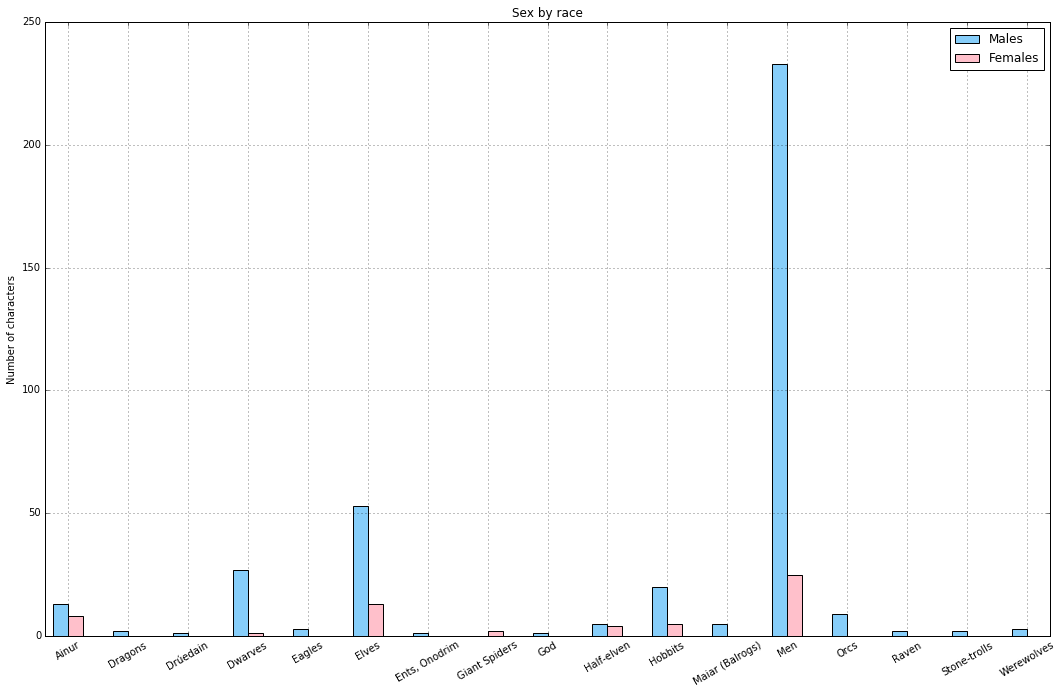

In [59]:
N = len(races_gender_counter.keys())

#Converting to list in order to be sure to keep the ordering (dict isn't ordered!)
items = sorted(races_gender_counter.items(),key=operator.itemgetter(0))
males = [item[1]['Males'] for item in items]
females = [item[1]['Females'] for item in items]

ind = np.arange(N)    # the x locations for the groups
width = .25       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(18,11))
p1 = plt.bar(ind - width/2.0, males, width, color='lightskyblue')
p2 = plt.bar(ind + width/2.0, females, width, color='pink')

plt.ylabel('Number of characters')
plt.title('Sex by race')
plt.xticks(ind + width/2.0, [item[0] for item in items],rotation=30)
plt.legend((p1[0], p2[0]), ('Males', 'Females'))
plt.xlim(-width,len(items)-1 + 2.0*width)
plt.ylim()
plt.grid()
plt.show()

### 3.5 - Script Parsing

First some functions to clean up the data. The first function will be useful since in the scripts the distinction between upper and lower case is often ignored, and we will often need to match *a part of the regex* indifferently upper or lower case. The second one cleans the scripts, removing html tags, director's notes and script-related tags (for example, the V.O. means that the voice comes from outside the scene). For the books we clean up tags as well, and use the word RUNE to indicate where images with runes are present.

In [60]:
# function to make a regular expression case insensitive
def caseinsensify(strg, addspaces=''):
    inter = ''
    if addspaces != '':
        inter = addspaces + r'?'
    
    ret = inter
    for c in strg:
        if c.isalpha():
            ret += r'[' + c.lower() + c.upper() + r']' + inter
        else:
            ret += c + inter
    return ret

def cleanupfromformats_s(script):
    # clean tags and script notes
    script = re.sub(r'</?b>', '', script)
    script = re.sub(r"\(" + caseinsensify("cont'd", " ") +"\)", '', script)
    script = re.sub(r"\( ?V ?\. ?O ?\. ?\)", '', script)
    script = re.sub(r"V/0", '', script)
    script = re.sub(r"\( ?[O0] ?\. ?S ?\. ?\)", '', script)
    script = re.sub(r" O\.S", '', script)
    script = re.sub(r"Final Revision - October, 2003", '', script)
    script = re.sub(u"\xb7", '', script)
    
    more   = r'(:?\(M[oO°]RE\))?'
    contd  = r'\( ?C ?O ?N ?T ?I ?N ?U ?E ?D ?\)'
    contd2 = r"CONTINUED:\s*?(?:\(\s*[0-9]+\s*\))?"
    script = re.sub(more + r"\s*?" + contd + r"\s*?[0-9]*?[.,]*?\s*?" + contd2, '\n\n', script)
    
    return unidecode(script)

def cleanupfromformats_b(script):
    # clean tags and script notes
    script = re.sub(r'\n', ' ', script)
    script = re.sub(r'</?[bi]>', '', script)
    script = re.sub(r'<p>', '', script)
    script = re.sub(r'</p>', '\n', script)
    script = re.sub(r'</?h[0-9]>', '\n*T*\n', script)
    
    script = re.sub(r'<a .*?>\w*</a>', '', script)
    script = re.sub(r'<' + caseinsensify('img src') + r'.*?>', ' *RUNE* ', script)
    script = re.sub(r'<\?t[rd]*?>', '', script)
    
    return unidecode(script)

#Code to read books and scripts from file (N.B already basically trimmed)
alls =[]
path_of_txts = 'texts/'
for name in ['book1','book2','book3','script1','script2','script3']:
    with codecs.open(path_of_txts + name + '.txt','r', 'utf8') as f:
        alls.append(f.read())

alls = [cleanupfromformats_b(b) for b in alls[:3]] + \
        [cleanupfromformats_s(s) for s in alls[3:]]
        
print 'done'

done


No easy way is provided in the script to understand when the dialogue of a character ends. We have identified that this happens almost always (the almost is once again caused by the imperfect real world data that we are handling) when two subsequent newlines appear; so we use it as a split indicator:

In [61]:

def splitwhendoublenewline(script):
    listofpos = []
    # split the double newlines, with junk in the middle
    boldtag = r'(:?(:?</?b>)|\s)*'
    p = re.compile('\n' + boldtag + '\n')
    prev_end = 0
    for m in p.finditer(script):
        listofpos.append( (prev_end, m.start()) )
        prev_end = m.end() #end is the first left out
    listofpos = listofpos + [(prev_end, len(script))]
    if listofpos[0] == (0,0):
        listofpos = listofpos[1:]
    if len(script) == prev_end:
        listofpos.pop()
    relevantlines = []
    for i,j in listofpos:
        relevantlines.append(script[i:j])
    
    return relevantlines




Once again, the data is very noisy: each script has different director's comments and different ways to indicate any scene information. We also needed to split the scenes: turns out that in the first and third scripts, this happens every time a location information is present (starting with INT or EXT, e.g. "EXT. SHIRE LANE -- DAY"). On the other side, the second script has a change in the scene whenever two director's comments are present after each other (in this script, enclosed in square brackets).

In [62]:
def parsedialogs(script, number):
    if number not in [1,2,3]:
        raise ValueError('The 2nd parameter should be 1, 2 or 3 (movie number) and not %s' % str(number))
        
    relevantlines = splitwhendoublenewline(script)
   
    # distinguish dialogue lines and junk
    junk = []
    good = []
    junksignals = ['IMAGES:', 'IMAGE:', 'FADE UP:', 'SLOW MOTION:']
    intorext = r'(' + caseinsensify('int') + r'[.])|(' + caseinsensify('ext') + r'[.])'
    scenechange = False
    scenecount = 0
    
    for line in relevantlines:
        if (number !=2) and (re.search(intorext, line)):
            good.append(None)
            scenecount += 1
            junk.append(line)
            continue
            
        done=False
        for js in junksignals:
            done = done or line.startswith(js)
                    
        if done:
            junk.append(line)
            continue
            
        if '\n' not in line:
            junk.append(line)
        else:
            if re.match(r'\s*?\[(?:.|\n)+?\]\s*?', line):
                if number == 2:
                    if scenechange:
                        good.append(None)
                        scenechange = False
                        scenecount += 1
                    else:
                        scenechange = True
                junk.append(line)
            elif re.match(r'\s+', line):
                parts = string.split(line, '\n', 1)
                good.append( (
                        re.sub(r'[\s;:.,-]', '', parts[0]), 
                        parts[1].strip() 
                    ) )
            else:
                junk.append(line)
            
    print 'detected', scenecount , 'scene changes,', len(good) - scenecount, \
                'play lines and', len(junk) ,'junk lines'
    return good, junk

Let's see if it works!

In [63]:
splitted, junk = parsedialogs(alls[3], 1)


for line in splitted[:5]:
    if line==None:
        print '**********************'
    else:
        print '%20s : %s' % line

print '...'


detected 141 scene changes, 811 play lines and 920 junk lines
           GALADRIEL : (Elvish: subtitled)
          "I amar prestar sen: han mathon ne nen,
          han mathon ne chae...a han noston ned
          wilith."
              (English:)
          The world is changed: I feel it in the
          water, I feel it in the earth, I smell it
          in the air...Much that once was is lost,
          for none now live who remember it.
**********************
           GALADRIEL : It began with the forging of the Great
          Rings.
           GALADRIEL : Three were given to the Elves, immortal,
          wisest...fairest of all beings.
           GALADRIEL : Seven to the Dwarf Lords, great miners
          and craftsmen of the mountain halls.
...


In [64]:
txt = len([f for f in splitted if f!=None and re.search(caseinsensify('gandalf') , f[1])])
print 'gandalf is nominated in lines:', txt
print 'over a total of lines:', len([l for l in splitted if l!=None])
print 'percentage:', ( float(txt) / len(splitted)) * 100

gandalf is nominated in lines: 59
over a total of lines: 811
percentage: 6.1974789916


Good, now for all the scripts!

In [65]:
finalscripts = []
for i in range(1,4):
    t, _ = parsedialogs(alls[i+2], i)
    finalscripts.append(t)

detected 141 scene changes, 811 play lines and 920 junk lines
detected 155 scene changes, 812 play lines and 365 junk lines
detected 200 scene changes, 702 play lines and 1503 junk lines


In [66]:
allcharacters = []
for j in range(1,4):
    print '***** MOVIE %d *****' % (j,)
    characters = set([])
    for l in finalscripts[j-1]:
        if l != None and l[0].isupper():
            n = l[0]
            n = re.sub(r'[ ;:.,-]', '', n)
            characters.add(n)

    print len(characters)
    print characters, '\n'
    allcharacters.extend(characters)

allcharacters = set(allcharacters)
print 'total = ' + str(len(allcharacters))

***** MOVIE 1 *****
30
set(['GATEKEEPER', 'GALADRIEL', 'BUTTERBUR', 'SARUMAN', 'GIMLI', 'FARMERMAGGOT', 'BLACKRIDER', 'LEGOLAS', 'STRIDER', 'ORCOVERSEER', 'MERRY&PIPPIN', 'FRODODISAPPEARS', 'SAM', 'BILBO', 'ARWEN', 'FRODO', 'HALDIR', 'MERRY', 'ODOPROUDFOOT', 'LURTZ', 'BOROMIR', 'CELEBORN', 'GOLLUM', 'ISILDUR', 'PIPPIN', 'WITCHKING', 'HOBBITBOUNDER', 'GANDALF', 'ARAGORN', 'ELROND']) 

***** MOVIE 2 *****
57
set(['FARAMIR', 'MADRIL', 'GALADRIEL', 'SMEAGOL', 'GRIMA', 'DUNLANDMAN', 'SOLDIER', 'SARUMAN', 'HAMA', 'MORDORORC', 'GIMLI', 'WHITEWIZARD', 'LEGOLAS', 'SNAGA', 'RANGER2', 'ROHANCAPTAIN', 'WOMAN', 'UGLUK', 'SAM', 'FRODO', 'GONDORIANRANGER', 'OLDWOMAN', 'ARWEN', 'EOMER', 'MAUHUR', 'RANGER1', 'SOLDIER4', 'HALDIR', 'TREEBEARD', 'GRISHNAKH', 'MANFLESHURUK', 'MERRY', 'WARGRIDERS', 'HALETH', 'MANWITHMISSINGEYE', 'EOTHAIN', 'GAMLING', 'BOROMIR', 'SOLDIERS', 'THEODEN', 'EOWYN', 'FREDA', 'CROWD', 'SHARKU', 'RANGER', 'GOLLUM', 'DAMROD', 'MORWEN', 'SOLDIER1', 'BEREG', 'PIPPIN', 'SOLDIER2', 'SOLD

### 3.6 - Networks from the scripts

We'll build two graphs from the scripts: one is the graph of the characters that appear in the same scene (i.e. each scene adds a clique), the other one is the network of the nomination: A is connected to B if A nominates B at least once in the three scripts.

network of characters that are in the same scene: nodes 102 edges 529


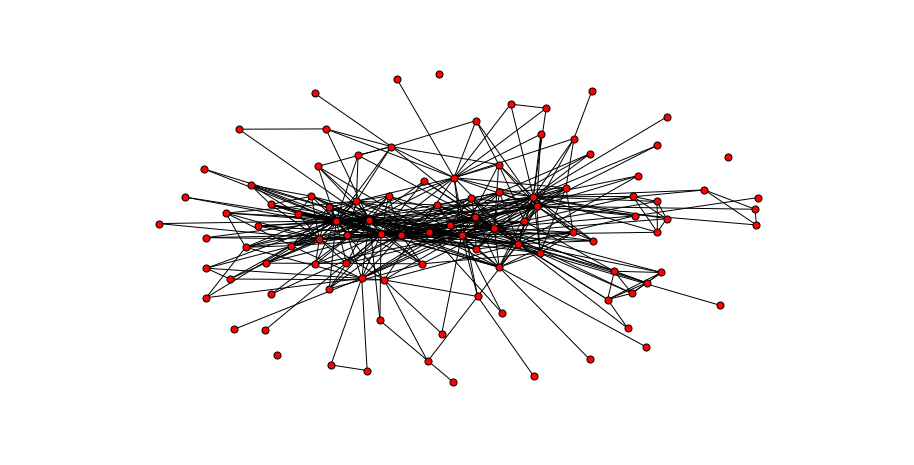

In [67]:
def connectall(g, b):
    l = list(b)
    for i in range(len(l)):
        for j in range(i,len(l)):
            g.add_edge(l[i], l[j])

samescene = nx.Graph()

bunch = set([])
for j in range(1,4):
    for l in finalscripts[j-1]:
        if l != None:
            bunch.add(l[0])
        else:
            connectall(samescene, bunch)
            bunch = set([])
    connectall(samescene, bunch)
    bunch = set([])

print 'network of characters that are in the same scene: nodes',len(samescene), 'edges', len(samescene.edges())

plt.figure(num=1, figsize=(12, 6), dpi=80)
nx.draw(samescene,node_size = 50)

giant component 99
other components 1 1 1


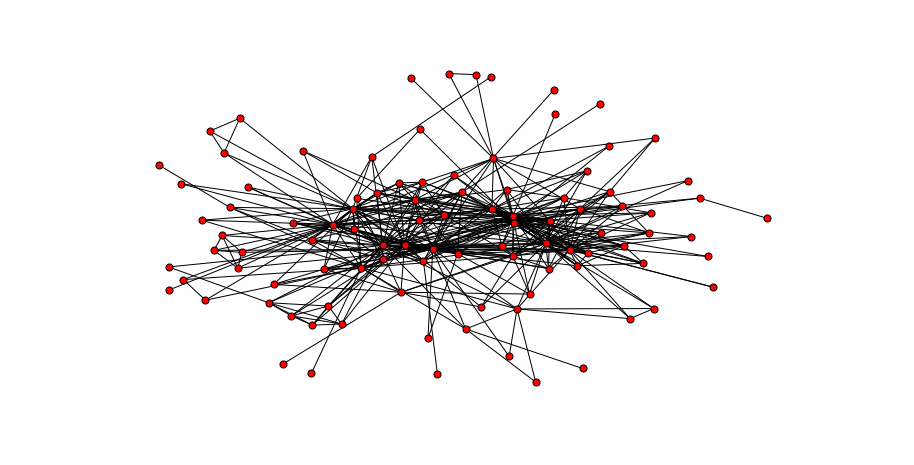

In [68]:
components = sorted(nx.connected_component_subgraphs(samescene), key=len, reverse = True)
samescene_gcc = components[0]

print 'giant component', len(samescene_gcc)
print 'other components', ' '.join([  str(len(i)) 
                                    #+ str(i.nodes()) 
                                    for i in components[1:]  ])

plt.figure(num=3, figsize=(12, 6), dpi=80)
nx.draw(samescene_gcc,node_size = 50)

In [69]:
graph_nodes_stats(samescene_gcc)

+---------+------------------------+
|   Node  | Betweenness Centrality |
+---------+------------------------+
|  FRODO  |     0.152812145474     |
| GANDALF |     0.137439686811     |
|  GIMLI  |     0.134444823655     |
| ARAGORN |     0.125665750729     |
| THEODEN |     0.123582440396     |
|   SAM   |     0.108544080158     |
|  PIPPIN |     0.099168307187     |
|  MERRY  |    0.0842653940689     |
| SARUMAN |    0.0727878149305     |
| FARAMIR |    0.0724664133556     |
+---------+------------------------+
+---------+------------------------+
|   Node  | Eigenvector Centrality |
+---------+------------------------+
| ARAGORN |     0.292442035801     |
| GANDALF |     0.275686915584     |
|  GIMLI  |     0.270434666327     |
|  MERRY  |     0.240419977974     |
| THEODEN |     0.239480891573     |
|   SAM   |     0.232480443275     |
| LEGOLAS |     0.229486849962     |
|  FRODO  |     0.224148895892     |
|  PIPPIN |     0.221026718294     |
| GAMLING |     0.184621435259     |
+

Aragorn is in the same scene with more characters, but it's Frodo that connects characters that are more far away, being the one that leads the fellowship throughout their journey!

network of characters that nominate each other: nodes 97 edges 272


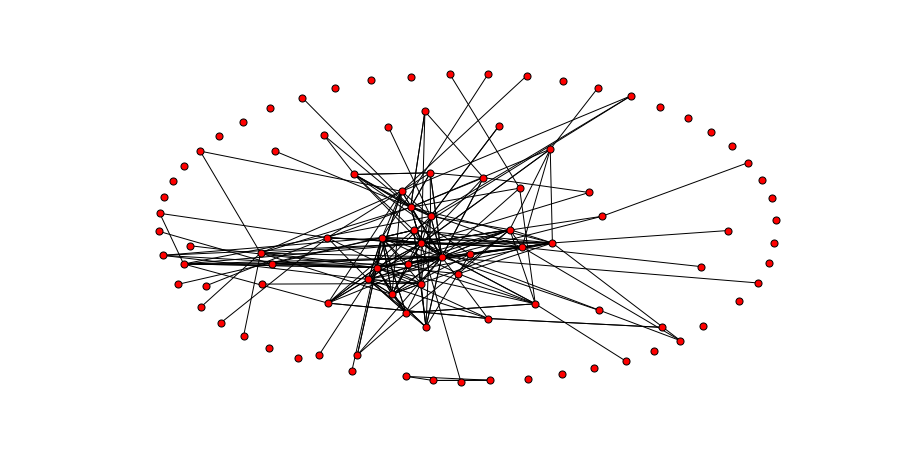

In [70]:
nominee = nx.DiGraph()

nominee.add_nodes_from(allcharacters)

for j in range(1,4):
    for l in finalscripts[j-1]:
        if l != None:
            for ch in allcharacters:
                if re.search(r'\b' + caseinsensify(ch.lower(), ' ') + r'\b', l[1].lower()):
                    #nominee.add_edge(ch, l[0])
                    nominee.add_edge(l[0], ch)


print 'network of characters that nominate each other: nodes',len(nominee), 'edges', len(nominee.edges())

plt.figure(num=3, figsize=(12, 6), dpi=80)
nx.draw(nominee,node_size = 50, arrows = False)

giant component 67
other components 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


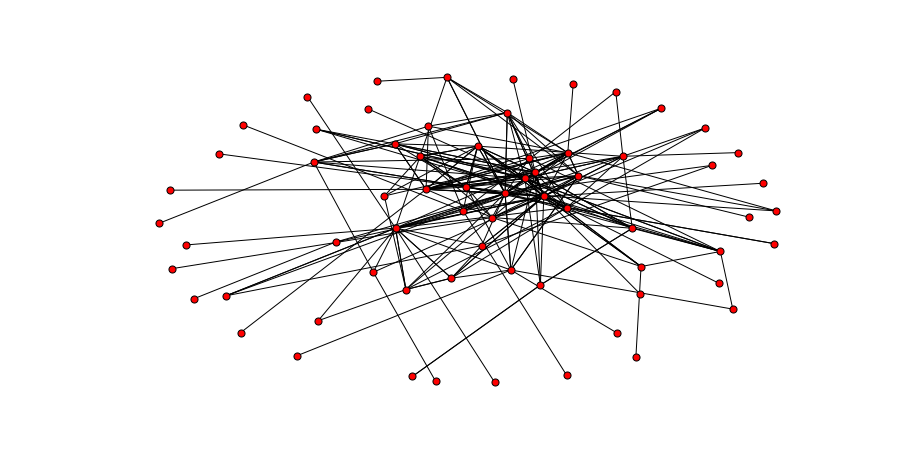

In [71]:
components = sorted(nx.weakly_connected_component_subgraphs(nominee), key=len, reverse = True)
nominee_gcc = components[0]

print 'giant component', len(nominee_gcc)
print 'other components', ' '.join([  str(len(i))
                                    #+ str(i.nodes())
                                    for i in components[1:]  ])

plt.figure(num=4, figsize=(12, 6), dpi=80)
nx.draw(nominee_gcc,node_size = 50, arrows=False)

In [72]:
graph_nodes_stats(nominee_gcc)

+----------+------------------------+
|   Node   | Betweenness Centrality |
+----------+------------------------+
| GANDALF  |     0.159341563513     |
| ARAGORN  |     0.128795883862     |
| THEODEN  |    0.0945805272169     |
|  FRODO   |    0.0695847466442     |
|   SAM    |    0.0460394044572     |
| BOROMIR  |    0.0397262330392     |
| SARUMAN  |    0.0370982905983     |
| FARAMIR  |    0.0295259370259     |
|  EOWYN   |    0.0279345035307     |
| DENETHOR |    0.0272404305097     |
+----------+------------------------+
+---------+------------------------+
|   Node  | Eigenvector Centrality |
+---------+------------------------+
| GANDALF |     0.361171651164     |
|  FRODO  |     0.357927810354     |
| ARAGORN |     0.309113560762     |
|   SAM   |     0.29054653771      |
| SARUMAN |     0.274405108967     |
| BOROMIR |     0.258531063856     |
|  PIPPIN |     0.241970888344     |
|   ORCS  |     0.20612052525      |
| STRIDER |     0.185615788509     |
|  MERRY  |     0.170651

This time Gandalf is the king! It's both the more nominated and the one that nominates the most characters! Also he dominates the shortest paths with its outstanding betweenness centrality! PHEW!

Note that in both graphs there are some characters that are disconnected: it's secondary characters that talk once or twice: have you ever heard of ORC2?

### 3.7 - Word Statistics in books and scripts

#### 3.7.1 - Temporal analysis

In [73]:
nltktexts = [ nltk.Text(nltk.word_tokenize(t.lower()))  for t in alls]

allbooks =  nltk.Text(nltk.word_tokenize(
                ' '.join([t.lower() for t in alls[:3]])
            ))  
allscripts= nltk.Text(nltk.word_tokenize(
                ' '.join([t.lower() for t in alls[3:]])
            ))  

For the books and the movies, frodo and sam dominate the scene in almost all the trilogy! But in the second and third book we can see that their adventure is paused for a while, when the rest of the fellowship gets the focus!

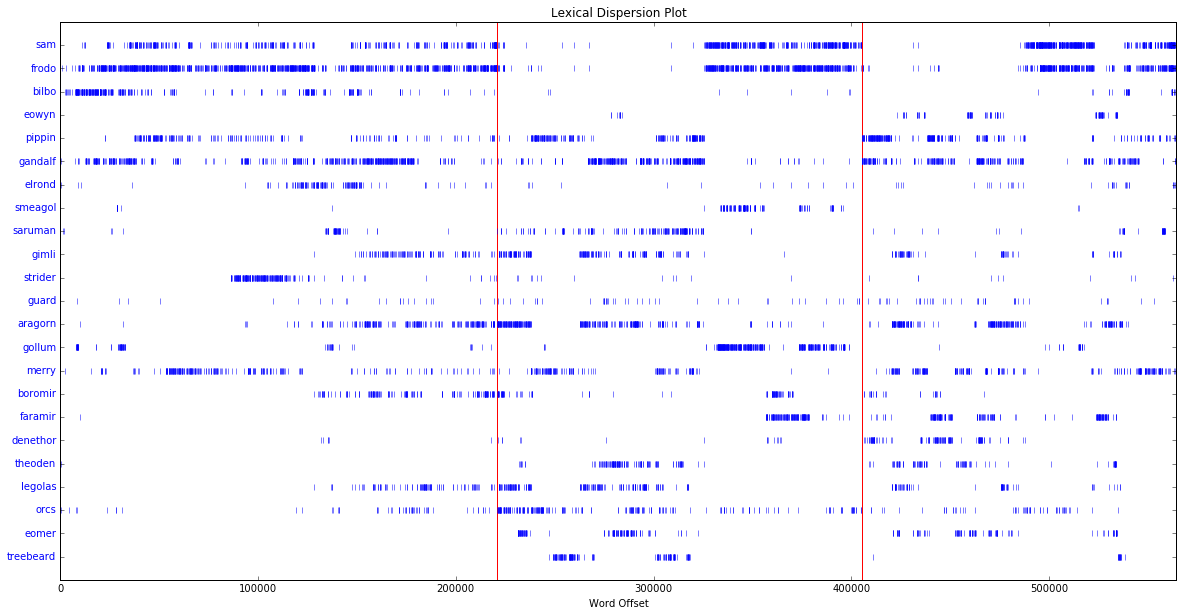

In [74]:
# word diagram, filter less important characters
fdist_books = nltk.FreqDist(allbooks.tokens)

filteredcharacters = [c.lower() for c in allcharacters if fdist_books[c.lower()] > 100]



plt.figure(num=4, figsize=(20, 10), dpi=80)
plt.vlines(len(nltktexts[0]), -1, len(filteredcharacters), 'r')
plt.vlines(len(nltktexts[0]) + 1 + len(nltktexts[1]), -1, len(filteredcharacters), 'r')
plt.xlim( 0,  len(nltktexts[0]) + 1 + len(nltktexts[1]) +  len(nltktexts[2])  )
allbooks.dispersion_plot(filteredcharacters)

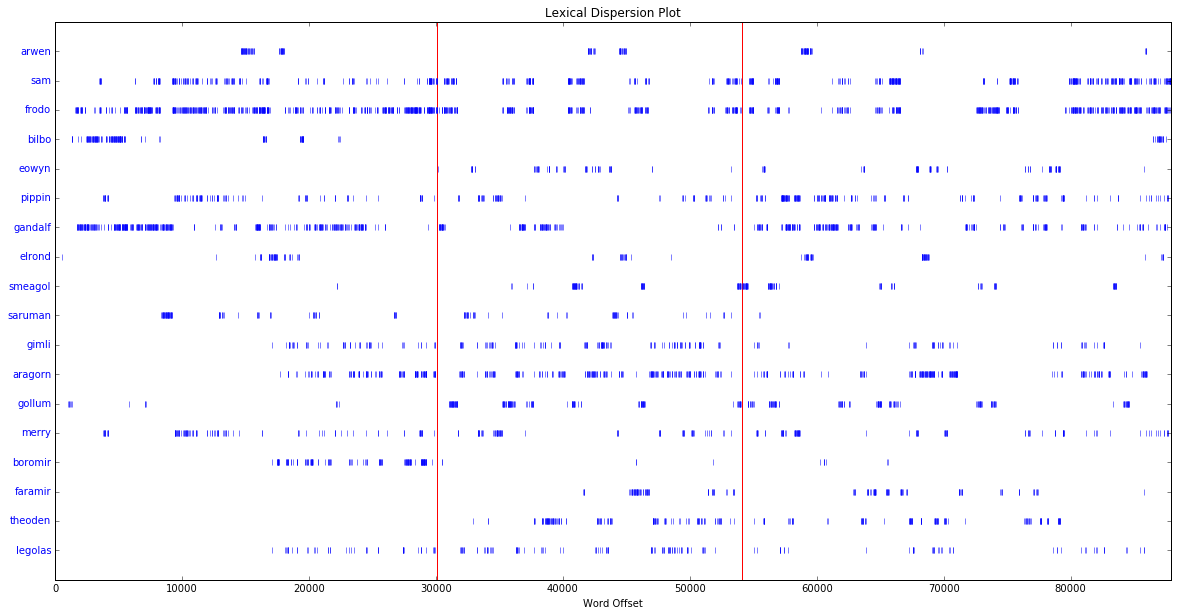

In [75]:
# word diagram, filter less important characters
fdist_scripts = nltk.FreqDist(allscripts.tokens)

filteredcharacters = [c.lower() for c in allcharacters if fdist_scripts[c.lower()] > 100]


plt.figure(num=5, figsize=(20, 10), dpi=80)
plt.vlines(len(nltktexts[3]), -1, len(filteredcharacters), 'r')
plt.vlines(len(nltktexts[3]) + 1 + len(nltktexts[4]), -1, len(filteredcharacters), 'r')
plt.xlim( 0,  len(nltktexts[3]) + 1 + len(nltktexts[4]) +  len(nltktexts[5])  )
allscripts.dispersion_plot(filteredcharacters)

Looks like someone has a double personality (but not Sune, thanks God!).

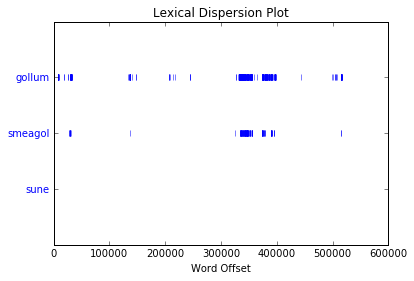

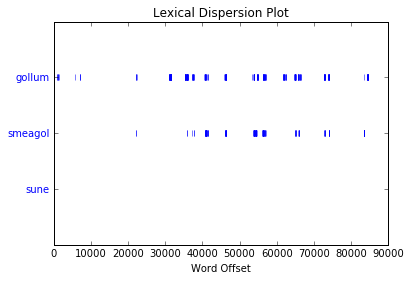

In [76]:
zoom = ['gollum', 'smeagol', 'sune']

allbooks.dispersion_plot(sorted(zoom)) # undocumentedly, the dispersion plot reverses the list in place...

allscripts.dispersion_plot(sorted(zoom))

Frodo and Gandalf are similar?

In [77]:
for i in range(len(nltktexts)):
    nltktexts[i].similar('gandalf')
    print
    nltktexts[i].collocations()
    print '----------------------'

frodo it aragorn you sam he i that merry pippin bilbo strider the
elrond they all boromir and him legolas

said frodo; said gandalf; bag end; minas tirith; long ago; said
aragorn; tom bombadil; far away; could see; said merry; mr. butterbur;
*t* chapter; black riders; misty mountains; said pippin; said strider;
n't know; *t* *t*; said sam; either side
----------------------
frodo aragorn faramir gimli sam legolas that he theoden gollum it
eomer merry i pippin you and all the treebeard

said aragorn; said frodo; said gandalf; said gimli; minas tirith; said
legolas; far away; said faramir; mr. frodo; emyn muil; said sam; said
merry; old man; 've got; either side; *t* chapter; could see; long
ago; said pippin; said theoden
----------------------
frodo sam aragorn pippin merry he they it eomer faramir you theoden
that beregond him there i eowyn denethor them

minas tirith; mr. frodo; said gandalf; dol amroth; said frodo; said
pippin; bag end; far away; said sam; said aragorn; *t* chapter; 

#### 3.7.2 - Sentiment over books and scripts

Let's go for the sentiment over books and movies! We will just consider a window of 500 words, since a lower amount did not show much of a structure, and a higher one started blurring too much.

The plots will be in percentage for the x axis, so to highlight any parallel between book and movie.

In [78]:
sentiment_value_dict = {}

with open('texts/asset.txt','r') as f:
    _,_,_,_ = f.readline(), f.readline(), f.readline(), f.readline()
    for l in f:
        sentiment_value_dict[l.split()[0]] = float(l.split()[2])
        
sentiment_value_keys = set(sentiment_value_dict.keys())

print 'Created sentiment values dictionary.'

def fromlistoftokenstosentiment(l_o_t):
    sentiments = []
    if len(l_o_t) == 0:
        return 'ERROR'
    
    for token in l_o_t:
        if token in sentiment_value_keys:
            sentiments.append(sentiment_value_dict[token])
        else:
            return 'ERROR'
    
    return float(np.average(sentiments))


Created sentiment values dictionary.


Plotting...
Sentiment profile for window = 500 words


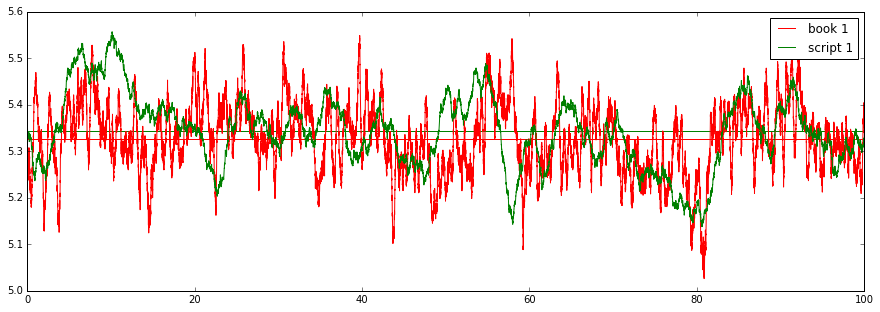

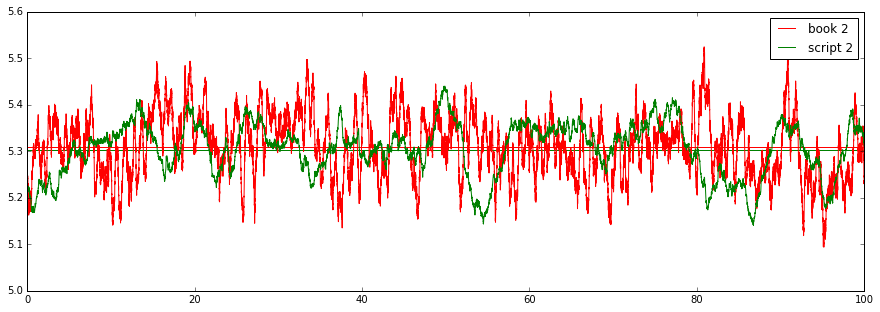

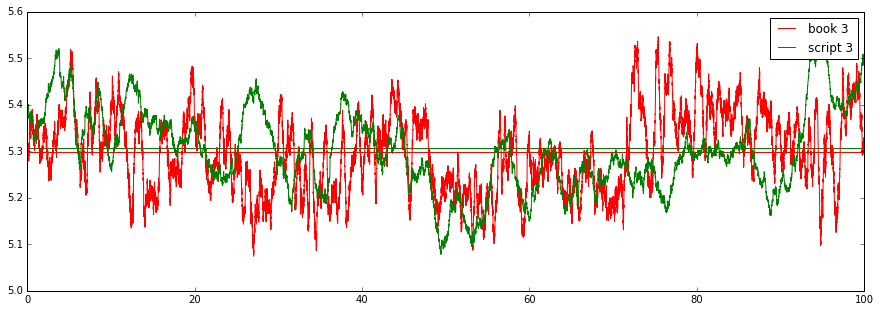

In [79]:
def movingaverage(tokenvector, w):    
    wneg = w/2
    wpos = w - wneg
    results = []
    
    # first position:
    results.append(fromlistoftokenstosentiment( 
            tokenvector[0:w] 
                ))
    
    # following positions
    for newtoken in range(w, len(tokenvector)):
        add = fromlistoftokenstosentiment([  tokenvector[newtoken]    ])
        rmv = fromlistoftokenstosentiment([  tokenvector[newtoken-w]  ])
        value = (results[newtoken-w]*w + add - rmv) / float(w)
        results.append(value)
    
    return results

def compute_textsent(window, text):
    goodtokens = [tok.lower() for tok in text.tokens if tok in sentiment_value_keys]

    text_sent_dict = movingaverage(goodtokens, window)
    avg = fromlistoftokenstosentiment(goodtokens)

    return text_sent_dict, avg

def plotsentiment(sents, labels, averages):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k'][:len(sents)]
    plt.figure(figsize=(15, 5), dpi=80)
    for array, label, color, average in zip(sents, labels, colors, averages):
        plt.plot(
            np.arange(0,101,100.0/len(array))[0:len(array)],
            #range(w/2, w/2 + len(averagetoplot)), 
            array, 
            color,
            label=(label)
        )
        plt.hlines(average, 0, 100, color)
    plt.ylim( 5,5.6 )
    plt.xlim( 0,100 )
    plt.legend()
    plt.show()

    
    
print 'Plotting...'
window = 500

print 'Sentiment profile for window = %d words' % (window,)
all_sents_500 = []
all_avgs = []
for t in nltktexts:
    text_sent, avg = compute_textsent(window, t)
    all_sents_500.append(text_sent)
    all_avgs.append(avg)
    
for i in [0,1,2]:
    plotsentiment(all_sents_500[i::3], ['book ' + str(i+1), 'script ' + str(i+1)], all_avgs[i::3])


The first book and movie are surprisingly similar! The second is quite different in sentiment but still we can recognize the peaks and valleys in both. But in the third one a huge difference appears, especially in the last quarter of both... So, who said that the third movie left out some important part may be true!

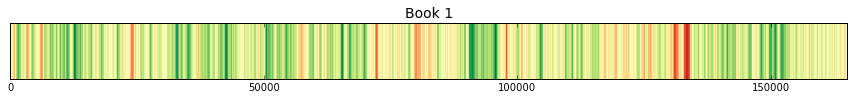

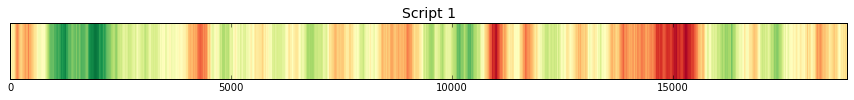

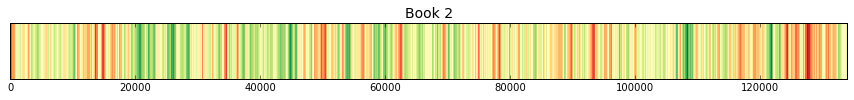

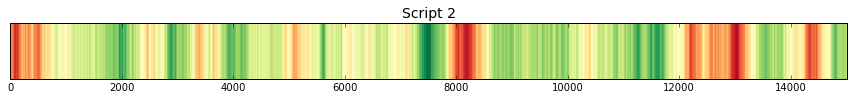

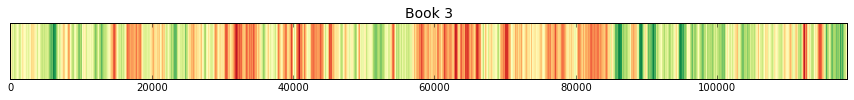

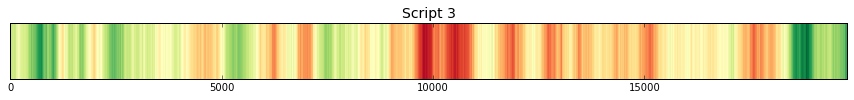

In [80]:
plot_sents = [all_sents_500[i] for i in [0,3,1,4,2,5]]
titles = ['Book 1', 'Script 1', 'Book 2', 'Script 2','Book 3', 'Script 3']
for g in plot_sents:
    plt.figure(figsize=(15, 1), dpi=80)
    plt.gca().get_yaxis().set_ticks([])
    gradient = np.vstack((g, g))
    plt.title(titles.pop(0), fontsize=14)
    plt.imshow(gradient, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    plt.show()

In [81]:
all_sent_15 = [compute_textsent(15, t)[0] for t in nltktexts]

print 'ok'

ok


For fun, let's find the happiest and saddest sentences of the books and movies (sentence means 15 sentiment-words gap with other words inbetween)!

In [82]:
def find_sentence_from_happiness(tt, minimum):
    if not minimum:
        m = min(all_sent_15[tt])
    else:
        m = max(all_sent_15[tt])

    m_happiest = [ind for ind in range(len(all_sent_15[tt]))
                    if all_sent_15[tt][ind] == m
                   ][0]
    
    m_start = -1
    m_end = -1
    j = -1
    for i in range(len(nltktexts[tt].tokens)):
        if nltktexts[tt].tokens[i] in sentiment_value_keys:
            j = j + 1
        if j == m_happiest and m_start == -1:
            m_start = i
        elif j == 15 + m_happiest:
            m_end = i
    return m_start, m_end

names = [a+b for a in ['Book ', 'Script '] for b in['1','2','3'] ]
for t in range(len(nltktexts)):
    print '=== ' + names[t] + ' ==='
    i, j = find_sentence_from_happiness(t,True)
    h_tokenslist = nltktexts[t].tokens[i:j+1] #up including j
    print 'HAPPIEST %.2f:' % (fromlistoftokenstosentiment([tk for tk in h_tokenslist if tk in sentiment_value_keys])),
    print ' '.join(h_tokenslist)
    
    i, j = find_sentence_from_happiness(t,False)
    s_tokenslist = nltktexts[t].tokens[i:j+1] #up including j
    print 'SADDEST  %.2f:' % (fromlistoftokenstosentiment([tk for tk in s_tokenslist if tk in sentiment_value_keys])),
    print ' '.join(s_tokenslist)
    print


=== Book 1 ===
HAPPIEST 6.33: journey . now we will wish you all a fair night and untroubled sleep . ' 'good night , my friends ! ' said galadriel . 'sleep
SADDEST  4.12: pursued by his enemy 's cries of hate and despair : thief , thief ! baggins ! we hates it for

=== Book 2 ===
HAPPIEST 6.37: song about her . beautiful she is , sir ! lovely ! sometimes like a great tree in flower , sometimes
SADDEST  4.14: hurt you . ' 'it hurts us , it hurts us , ' hissed gollum . `it freezes , it bites ! elves twisted it , curse them ! nasty cruel hobbits ! that 's

=== Book 3 ===
HAPPIEST 6.35: many tongues : < blockquote > < blockquote > 'long live the halflings ! praise them with great praise ! cuio i pheriain anann ! aglar'ni pheriannath ! praise them with great praise , frodo and samwise ! daur
SADDEST  4.11: at last : 'eowyn , how come you here ? what madness or devilry is this ? death , death , death ! death take

=== Script 1 ===
HAPPIEST 6.25: super : new line cinema presents super : a win

(looks like script one is not that happy... the happiest sentence is the headline with the name of the production houses!)

#### 3.7.3 - TF IDF of the scripts

Let us also generate some word clouds, one for each character:

In [83]:
def cleantxtd(s):
    ss = s
    ss = unidecode(s)
    ss = re.sub(r'[\W]', ' ', ss.lower())
    ss = re.sub(r'\s+', ' ', ss)
    
    return ss

In [84]:
tfidfdict = {}
for pg in allcharacters:
    tfidfdict[pg] = ''

for p in finalscripts[0] + finalscripts[1] + finalscripts[2]:
    if p!= None and p[0] in allcharacters:
        a1,a2 = p
        adding = tfidfdict[p[0]].strip() + ' ' + cleantxtd(p[1]).strip()
        tfidfdict[p[0]] = adding

bigtxt = ' '.join(tfidfdict.values())
num_txt = len(tfidfdict)

/home/sev/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:46: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  _warn_if_not_unicode(string)


In [85]:
freqs = {}
for w in bigtxt.split(' '):
    jj = 0
    for pg in allcharacters:
        if w in tfidfdict[pg]:
            jj += 1
        
    freqs[w] = jj

print 'OK'

OK


In [86]:
uniq = set(bigtxt.split(' '))

#Calculating the IDF for each unique word:
idf = {}
for word in uniq:
    idf[word] = np.log(num_txt/freqs[word])

tf = {}
for page in tfidfdict.keys():
    tf[page] = nltk.FreqDist(tfidfdict[page].split(' '))

tf_idf = {}
#Iterating over all the articles (one TF-IDF vector per article)
for page in tfidfdict.keys():
    #Initializing the TF-IDF vector
    tf_idf[page] = {}

    #Iterating over the words of the text
    for word in tfidfdict[page].split(' '):
        tf_idf[page][word] = tf[page][word]*idf[word]



important_characters = ['FRODO','ARAGORN','GANDALF',
                        'LEGOLAS','GIMLI','ELROND','SAURON','GOLLUM',
                        'BOROMIR','ARWEN','SARUMAN']
mask_background = 'bg_wordcloud.jpg'
mask = np.array(Image.open(path_to_pictures+mask_background))

#Generating wordcloud
for page in tfidfdict.keys():
    if page in important_characters:
        s = generate_string(tf_idf[page])
        first_name = page.split()[0].lower()
        generate_wordcloud(mask,s,first_name + '_SCRIPTS')

print 'Generated!'

Generated!


### 3.8 - "In the movies, no 2 female characters ever talk to each other"

Now we want to explore the saying for which no two female character ever speak to each other. Well, we have the graphs, so we just need to dig into the edges!

In [87]:
genders_upper = { re.sub(r"[ .,'-]" , '' , unidecode(k.upper())) 
                 : v for (k,v) in genders.iteritems()}

pairs = []
for a,b in nominee_gcc.edges_iter():
    gendera = genderb = ''
    if a in genders_upper.keys():
        gendera = genders_upper[a]
    if b in genders_upper.keys():
        genderb = genders_upper[b]
    for k in genders_upper.iterkeys():
        if gendera == '' and k.startswith(a):
            gendera = genders_upper[k]
        if genderb == '' and k.startswith(b):
            genderb = genders_upper[k]
    if a != b and gendera == 'Female' and genderb == 'Female':
        pairs.append( (a,b) )
    
if pairs == []:
    print 'No female nominate each other.'
else:
    print 'Female that nominate each other: ' + pairs
    
print
    
pairs = []
for a,b in samescene_gcc.edges_iter():
    gendera = genderb = ''
    if a in genders_upper.keys():
        gendera = genders_upper[a]
    if b in genders_upper.keys():
        genderb = genders_upper[b]
    for k in genders_upper.iterkeys():
        if gendera == '' and k.startswith(a):
            gendera = genders_upper[k]
        if genderb == '' and k.startswith(b):
            genderb = genders_upper[k]
    if a != b and gendera == 'Female' and genderb == 'Female':
        pairs.append( (a,b) )

if pairs == []:
    print 'No female appear in the same scene.'
else:
    print 'Female pairs in the same scene: ' + str(pairs)


No female nominate each other.

Female pairs in the same scene: [('EOWYN', 'ARWEN'), ('EOWYN', 'MORWEN')]


Looks like no woman nominate another woman! But there appear to be some female characters in the same scene... Let's find these scenes.

In [88]:
def findtalkingcharacters (a,b):
    ret = []
    
    bunch = []
    bunchall = set([])
    for j in range(1,4):
        for l in finalscripts[j-1]:
            if l != None:
                bunch.append( (l[0], l[1]) )
                bunchall.add(l[0])
            else:
                if a in bunchall and b in bunchall:
                    s = ('======= BOOK %d =======\n' % j)
                    for el in bunch:
                        s = s + ('%20s : %s\n' % el)
                    ret.append(s)
                bunch = []
                bunchall = set([])
        bunch = []
        bunchall = set([])
                               
    return '\n\n'.join(ret)

for a,b in pairs:
    print findtalkingcharacters(a,b)
    print


======= BOOK 2 =======
               EOWYN : Ooh! [She rushes forward to Gimli]
               GIMLI : [Struggling to get up] Its alright, 
                         its alright. Nobody panic. That was 
                         deliberate. It was deliberate.
               ARWEN : The light of the Evenstar does not wax 
                         and wane It is mine to give to whom 
                         I will... Like my heart Go to sleep...


======= BOOK 2 =======
               ARWEN : Ae u-esteliach nad... estelio han. Estelio 
                         ammen. (If you trust nothing else... 
                         trust this. Trust us.)
               EOWYN : Where is she? The woman who gave you 
                         that jewel.


======= BOOK 2 =======
             ARAGORN : This belongs to you.
               ARWEN : [Closes Aragorns hand over the Evenstar] 
                         It was a gift. Keep it.
               EOWYN : My lord?
             ARAGORN : She is sailin

Ok, no surprise! They never address each other, so **we confirm the saying!**

### 3.9 - Book parsing

In [89]:
url1 = "http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_1__en.htm"
url2 = "http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_2__en.htm"
url3 = "http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_3__en.htm"
def get_url_text(url):
    opened_url = urllib2.urlopen(url)
    return opened_url.read() # <-- read from it

In [90]:

def extract_books_from_page(url):
    url_text_result = get_url_text(url)
    bs = BeautifulSoup(url_text_result, "lxml") 
    #print bs
    books = []

    book_index = -1
    chapter_index = 0
    for header in bs.findAll(['b','h2','h3','i']):
        if header.parent.name == "body": #only children of body
            if "Book" in header.get_text(): #found a book (and the first chapter)
                book_index += 1
                books.insert(book_index, []) #array that will contain all the chapters in the book
                chapter_index = 0

            if book_index > -1 and "Chapter" in header.get_text():
                books[book_index].insert(chapter_index, "")
                for tag in header.findAllNext():
                    if tag.parent.name == "body":
                        if tag.name in ['b','h2','h3','i'] and ("Book" in tag.get_text() or "Chapter" in tag.get_text()):#"b" == tag.name: #and ("Book" in tag.next or "Chapter" in tag.next):
                            #print "Breaking chapter with ",tag.get_text()
                            break
                        elif "p" == tag.name: #note: after the book name there is the first chapter paragraph
                            books[book_index][chapter_index] += tag.get_text()
                chapter_index += 1
    return books
books = extract_books_from_page(url1) + extract_books_from_page(url2) + extract_books_from_page(url3)
print len(books),"books found"
print "chapters per book",[len(book) for book in books]


6 books found
chapters per book [12, 10, 9, 10, 10, 9]


In [91]:
def clean_text(text):   
    clean_text = unidecode(text)
    clean_text = re.sub(r'\W+'," ",text)#.lower()#re.sub("[\.\t\,\:;\(\)\.\’\‘]", " ", text, 0, 0)
    return clean_text

for j in range(len(books)):
    for i in range(len(books[j])):
        books[j][i] = clean_text(books[j][i])

In [92]:
stopwords = stopwords.words("english")+["Th","oden","owyn","Sm","agol","k","Ugl","kh"]

def find_tf_idf_from_book(book):
    set_all_words = set()
    all_words = []
    for i in range(len(book)):
        words_in_chapter = set()
        for word in [word for word in book[i].split() if word not in stopwords]:
            words_in_chapter.add(word)
            set_all_words.add(word)
        all_words.extend(words_in_chapter)

    #I create a list representation of the set, sorted alphabetically
    list_unique_words = sorted(set_all_words)

    #Free memory
    del set_all_words

    total_texts_len = len(book)
    freq_corpus =  nltk.FreqDist(all_words)
    #print freq_corpus['bilbo'],"freq corpus bilbo"
    #Calculating the IDF for each unique word:
    idf = {}
    for word in list_unique_words:
        idf[word] = np.log(total_texts_len*1.0/freq_corpus[word])

    tf = {}
    for i in range(len(book)):
        tf[i] = nltk.FreqDist([word for word in book[i].split() if word not in stopwords])

    tf_idf = {}

    #Iterating over all the articles (one TF-IDF vector per article)
    for i in range(len(book)):

        #Initializing the TF-IDF vector
        tf_idf[i] = {}

        #Iterating over the words of the text
        for word in [word for word in book[i].split() if word not in stopwords]:
            #print word, tf[i][word], idf[word]
            tf_idf[i][word] = tf[i][word]*idf[word]
    return tf_idf

In [93]:
def print_table(data,column_names):
    table = PrettyTable()
    table.field_names = column_names
    for row in data:
        table.add_row(row)
    print table
    
for i in range(len(books)):
    print "Book",(i+1),"chapters TF-IDF:"
    tf_idf = find_tf_idf_from_book(books[i])
    for j in range(len(tf_idf)):
        print "Chapter",(j+1),"(",len(tf_idf[j])," words)"
        data = sorted(tf_idf[j].iteritems(),key=operator.itemgetter(1),reverse=True)[:5]
        data = [(elm[0],round(elm[1],2)) for elm in data]
        print_table(data,["Word","TF-IDF"])


Book 1 chapters TF-IDF:
Chapter 1 ( 1996  words)
+-----------+--------+
|    Word   | TF-IDF |
+-----------+--------+
|  presents | 27.33  |
|   Gaffer  | 23.29  |
|  birthday | 18.02  |
| Sackville | 16.64  |
|    joke   | 16.13  |
+-----------+--------+
Chapter 2 ( 1847  words)
+--------+--------+
|  Word  | TF-IDF |
+--------+--------+
| Gollum | 53.75  |
|  ring  | 23.64  |
| Rings  | 22.36  |
| hated  | 19.88  |
|  Ted   | 19.88  |
+--------+--------+
Chapter 3 ( 1686  words)
+--------+--------+
|  Word  | TF-IDF |
+--------+--------+
| Gildor | 17.51  |
| Gaffer | 16.13  |
| rider  | 13.86  |
|  End   | 12.48  |
|  lane  | 10.99  |
+--------+--------+
Chapter 4 ( 1160  words)
+--------+--------+
|  Word  | TF-IDF |
+--------+--------+
| farmer | 44.73  |
| Maggot | 33.27  |
|  dogs  | 25.08  |
| Ferry  | 18.02  |
|  lane  | 15.38  |
+--------+--------+
Chapter 5 ( 1082  words)
+---------+--------+
|   Word  | TF-IDF |
+---------+--------+
|  Maggot | 11.09  |
|   Hall  | 11.09  |

---

# 4 - Discussion. Think critically about your creation

## What went well
The sentiment analysis comparison between the books and the movie scripts resulted in an interesting similarity regarding the first part of the trilogy. From the second movie (comparable to the second and third book) this similarity starts to diverge: the book is resulting in more positive words.

The comparison between books and movies also provided very interesting results and in general we were pretty much satisfied that all our initial goals about the project were fully achieved with great success. Now we now more about the LOTR universe, we know more about each character and race and we hope we collected and provided a lot of new material that can be pleasant to read for everybody through the awesome website.
## What can be improved?
Graphs analysis can put a focus on characters (so excluding battles and cities names) and to include parameters such as death, age, sex of a character.
Find more meaningful relations between the wiki, scripts and the book, in order to extract even more curious results about LOTR universe. Perhaps we could go more in depth with the community detection and if somebody will ever launch a *wikispeedia* project for LOTR, we'll be able to compare our results for the shortest paths similarities with some human paths similarities.